# Notebook for analysing all VR trials in one experiment folder

## (assumes use of FlyOver version 9.2 or higher)


In [1]:
import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk
from os.path import isfile, sep
from sys import path, exit
from glob import glob

from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

path.insert(1, '/Users/hannah/Dropbox/code/flyVR/flyVRAnalysis/')
from flyVR_oneTrialBasicAnalysis import singleVRTrialAnalysis

path.insert(1, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import makeNestedPlotDirectory, myAxisTheme
from objectInteractionPlots import residencyWithHistograms_splitOnWalking, curvatureVsHeading_DistanceBoxplot,\
plotResidencyInMiniarena, radDistAngleCombiPlot
from flyTracePlots import plotPosInRange, plotFlyVRtimeStp, plotPolarTrace

path.insert(1, '/Users/hannah/Dropbox/code/trajectoryAnalysis/')
from trajectoryDerivedParams import relationToObject, cartesian2polar, polarCurvature, fitGMMtoSingleTrial
from plotsWithDataframe import plotVeloHeadingDistribution_flyVR_df, oneDimResidency_df, turnRatePerDistance

plotPolarTrace

%matplotlib inline 

# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['WTBxpBDPGal4m01', 'WTBxpBDPGal4m02', 'WTBxpBDPGal4m03', 'WTBxpBDPGal4m04', 'WTBxpBDPGal4m05', 'WTBxpBDPGal4m06', 'WTBxpBDPGal4m07', 'WTBxpBDPGal4m08', 'WTBxpBDPGal4m09', 'WTBxpBDPGal4m10', 'WTBxpBDPGal4m11', 'WTBxpBDPGal4m12', 'WTBxpBDPGal4m13', 'WTBxpBDPGal4m14', 'WTBxpBDPGal4m15', 'WTBxpBDPGal4m16', 'WTBxpBDPGal4m17', 'WTBxpBDPGal4m18', 'WTBxpBDPGal4m19', 'WTBxpBDPGal4m20', 'WTBxpBDPGal4m21']
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


In [9]:
expDirs = expDirs[:20]
#from operator import itemgetter
#my_indices = [3,9,18] #[1,2,3,4,5,9,10,14,15,17,18]
#expDirs = itemgetter(*my_indices)(expDirs)

### Compose mutli-fly data into dataframe

In [10]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

In [11]:
expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [12]:
keylist = ['curvature','gamma','gammaFull','headingAngle','objectDistance','rotVelo','time',
           'transVelo','xPos','xPosInMiniarena','yPos','yPosInMiniarena']

keylistLong = ['flyID','trial','trialtype','moving','walking'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

In [13]:
nTrialsVI = 0
nTrialsIN = 0
 
vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:

        flyID = fileToAnalyse.split('_')[0]
        genotype = fileToAnalyse.split('_')[0][:-3]
        trial = FODataFiles.index(fileToAnalyse) + 1
        
        if rerunbasicanalysis == 'y':
            returnVal = singleVRTrialAnalysis(expDir + fileToAnalyse)
            print('Ran analysis, now loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        else:
            print('Loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

        # Split into visible object trials and invisible object trials
        if 'Invisible' in fileToAnalyse or 'invisible' in fileToAnalyse:
            trialtype = 'invisible'
            nTrialsIN += 1
        else:
            trialtype = 'visible'
            nTrialsVI += 1
        
        # test if moving
        vTrans = np.copy(FODatLoad['transVelo'])
        moving = vTrans >= vTransTH
        
        # test if in walking bout
        walkingboutTH = fitGMMtoSingleTrial(vTrans,False)
        vTrans_filt = np.copy(vTrans)
        vTrans_filt[vTrans_filt>30.0] = 0
        vTrans_filt = gaussian_filter(vTrans_filt, sigma=3)

        walking = (vTrans_filt>walkingboutTH).astype('bool')

        # add to data frame
        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'moving', moving)
        FODatLoad_df.insert(4, 'walking', walking)
        
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)
        
        # TODO: Add selection criteria, e.g. to only include trials from flies that were 
        # walking >40% of time and did not have a strong turn bias.
        


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m01/

 Analysing the following log files:

['WTBxpBDPGal4m01_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151106201158.txt', 'WTBxpBDPGal4m01_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151106202222.txt', 'WTBxpBDPGal4m01_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151106210311.txt', 'WTBxpBDPGal4m01_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_out_151106211619.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m02/

 Analysing the following log files:

['WTBxpBDPGal4m02_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151109184634.txt', 'WTBxpBDPGal4m02_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151109185826.txt', 'WTBxpBDPGal4m02_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151109192402.txt', 'WTBxpBDPGal4m02_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_out_151109191223.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m03/

 Analysing the following log files:

['WTBxpBDPGal4m03_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151109225138.txt', 'WTBxpBDPGal4m03_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151109230148.txt', 'WTBxpBDPGal4m03_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151109231411.txt', 'WTBxpBDPGal4m03_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_out_151109232651.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m04/

 Analysing the following log files:

['WTBxpBDPGal4m04_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151110174521.txt', 'WTBxpBDPGal4m04_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151110190458.txt', 'WTBxpBDPGal4m04_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151110191515.txt', 'WTBxpBDPGal4m04_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_out_151110185252.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m05/

 Analysing the following log files:

['WTBxpBDPGal4m05_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151110204856.txt', 'WTBxpBDPGal4m05_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151110205903.txt', 'WTBxpBDPGal4m05_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151110210929.txt', 'WTBxpBDPGal4m05_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_out_151110212133.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m06/

 Analysing the following log files:

['WTBxpBDPGal4m06_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151110214958.txt', 'WTBxpBDPGal4m06_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151110220019.txt', 'WTBxpBDPGal4m06_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_out_151110221211.txt', 'WTBxpBDPGal4m06_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_out_151110213704.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m07/

 Analysing the following log files:

['WTBxpBDPGal4m07_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5-6d_out_151114183356.txt', 'WTBxpBDPGal4m07_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5-6d_out_151114184401.txt', 'WTBxpBDPGal4m07_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5-6d_out_151114190835.txt', 'WTBxpBDPGal4m07_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_5-6d_out_151114185635.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m08/

 Analysing the following log files:

['WTBxpBDPGal4m08_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5-6d_out_151114193800.txt', 'WTBxpBDPGal4m08_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5-6d_out_151114195431.txt', 'WTBxpBDPGal4m08_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5-6d_out_151114202510.txt', 'WTBxpBDPGal4m08_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_5-6d_out_151114204100.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m09/

 Analysing the following log files:

['WTBxpBDPGal4m09_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5-6d_out_151115005936.txt', 'WTBxpBDPGal4m09_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5-6d_out_151115011014.txt', 'WTBxpBDPGal4m09_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5-6d_out_151115012032.txt', 'WTBxpBDPGal4m09_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_5-6d_out_151115004553.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m10/

 Analysing the following log files:

['WTBxpBDPGal4m10_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151116222927.txt', 'WTBxpBDPGal4m10_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151116223932.txt', 'WTBxpBDPGal4m10_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151116224935.txt', 'WTBxpBDPGal4m10_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_6d_out_151116221433.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m11/

 Analysing the following log files:

['WTBxpBDPGal4m11_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151117005048.txt', 'WTBxpBDPGal4m11_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151117010056.txt', 'WTBxpBDPGal4m11_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151117011101.txt', 'WTBxpBDPGal4m11_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_6d_out_151117012223.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m12/

 Analysing the following log files:

['WTBxpBDPGal4m12_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151117172406.txt', 'WTBxpBDPGal4m12_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151117174151.txt', 'WTBxpBDPGal4m12_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151117180639.txt', 'WTBxpBDPGal4m12_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_6d_out_151117175511.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m13/

 Analysing the following log files:

['WTBxpBDPGal4m13_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_7d_out_151118220635.txt', 'WTBxpBDPGal4m13_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_7d_out_151118221757.txt', 'WTBxpBDPGal4m13_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_7d_out_151118224155.txt', 'WTBxpBDPGal4m13_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_7d_out_151118222931.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m14/

 Analysing the following log files:

['WTBxpBDPGal4m14_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_7d_out_151118230922.txt', 'WTBxpBDPGal4m14_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_7d_out_151118234011.txt', 'WTBxpBDPGal4m14_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_7d_out_151118235015.txt', 'WTBxpBDPGal4m14_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_7d_out_151118232844.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m15/

 Analysing the following log files:

['WTBxpBDPGal4m15_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151120130634.txt', 'WTBxpBDPGal4m15_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151120132226.txt', 'WTBxpBDPGal4m15_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151120133243.txt', 'WTBxpBDPGal4m15_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_6d_out_151120134424.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m16/

 Analysing the following log files:

['WTBxpBDPGal4m16_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151120142835.txt', 'WTBxpBDPGal4m16_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151120143838.txt', 'WTBxpBDPGal4m16_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151120144929.txt', 'WTBxpBDPGal4m16_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_6d_out_151120141705.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m17/

 Analysing the following log files:

['WTBxpBDPGal4m17_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151120154328.txt', 'WTBxpBDPGal4m17_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151120160842.txt', 'WTBxpBDPGal4m17_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151120161848.txt', 'WTBxpBDPGal4m17_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_6d_out_151120155512.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m18/

 Analysing the following log files:

['WTBxpBDPGal4m18_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151123150244.txt', 'WTBxpBDPGal4m18_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151123151252.txt', 'WTBxpBDPGal4m18_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151123152326.txt', 'WTBxpBDPGal4m18_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_6d_out_151123145026.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m19/

 Analysing the following log files:

['WTBxpBDPGal4m19_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151123155109.txt', 'WTBxpBDPGal4m19_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151123160116.txt', 'WTBxpBDPGal4m19_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151123161121.txt', 'WTBxpBDPGal4m19_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_6d_out_151123162403.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTBxpBDPGal4/males/rawData/WTBxpBDPGal4m20/

 Analysing the following log files:

['WTBxpBDPGal4m20_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151124132019.txt', 'WTBxpBDPGal4m20_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151124133025.txt', 'WTBxpBDPGal4m20_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151124134041.txt', 'WTBxpBDPGal4m20_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_6d_out_151124135215.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)


In [14]:
FOAllFlies_df =FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')

FOAllFlies_df 

flyID trial  trialtype  moving  walking  curvature  gamma  \
0      WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
1      WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
2      WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
3      WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
4      WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
5      WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
6      WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
7      WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
8      WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
9      WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
10     WTBxpBDPGal4m01     1    visible       0        1        NaN    NaN   
11     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
12     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
13     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
14     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
15     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
16     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
17     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
18     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
19     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
20     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
21     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
22     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
23     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
24     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
25     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
26     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
27     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
28     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
29     WTBxpBDPGal4m01     1    visible       1        1        NaN    NaN   
...                ...   ...        ...     ...      ...        ...    ...   
11970  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11971  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11972  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11973  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11974  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11975  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11976  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11977  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11978  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11979  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11980  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11981  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11982  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11983  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11984  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11985  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11986  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11987  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11988  WTBxpBDPGal4m20     4  invisible       0        0        NaN    NaN   
11989  WTBxpBDPGal4m20     4  invisible

In [15]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_gam = keylistLong.index('gamma')
keyind_gamful = keylistLong.index('gammaFull')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')
keyind_walk = keylistLong.index('walking')

genotypeSex = fileToAnalyse.split('_')[0][:-2]

flyIDallarray = np.asarray(FOAllFlies_df.iloc[:,keyind_fly:keyind_fly+1]).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

arenaRad = 60

##Experimental conditions

In [53]:
visibilityState = ['visible','visible','visible','invisible']
groundPlane = ['texture','texture','texture','texture']
trialName = ['obj + tex','obj + tex','obj + tex','tex']
arenaRad = 60

## Summary plot of walking traces

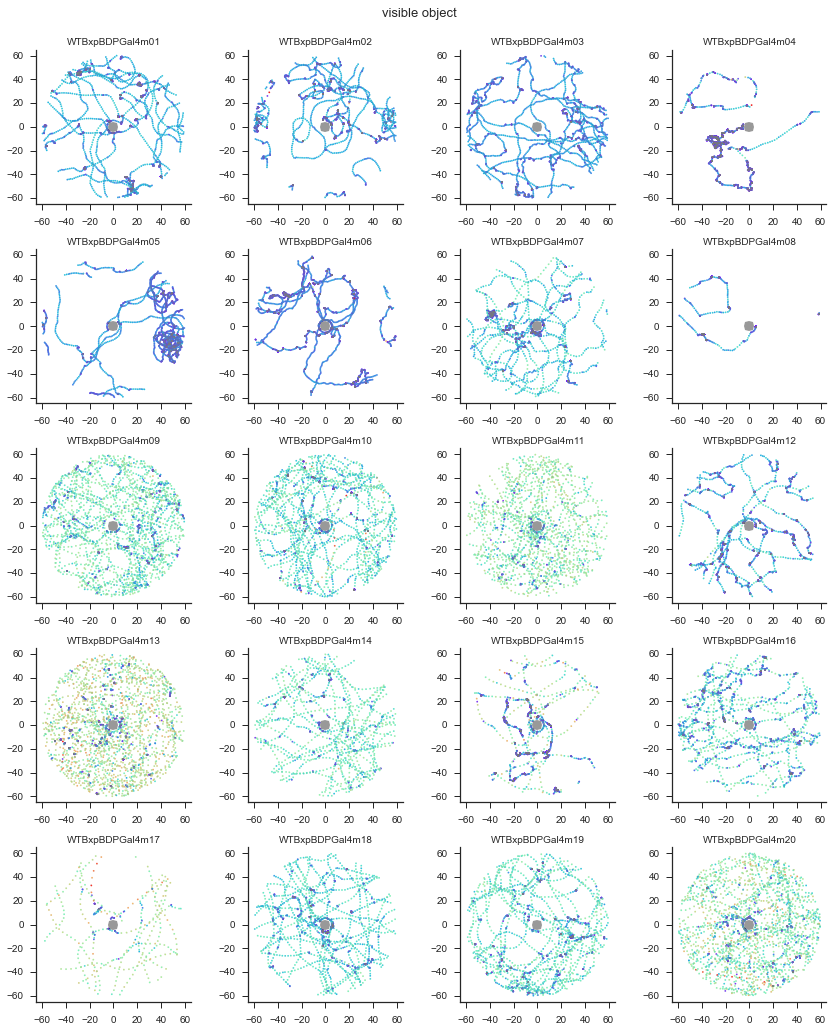

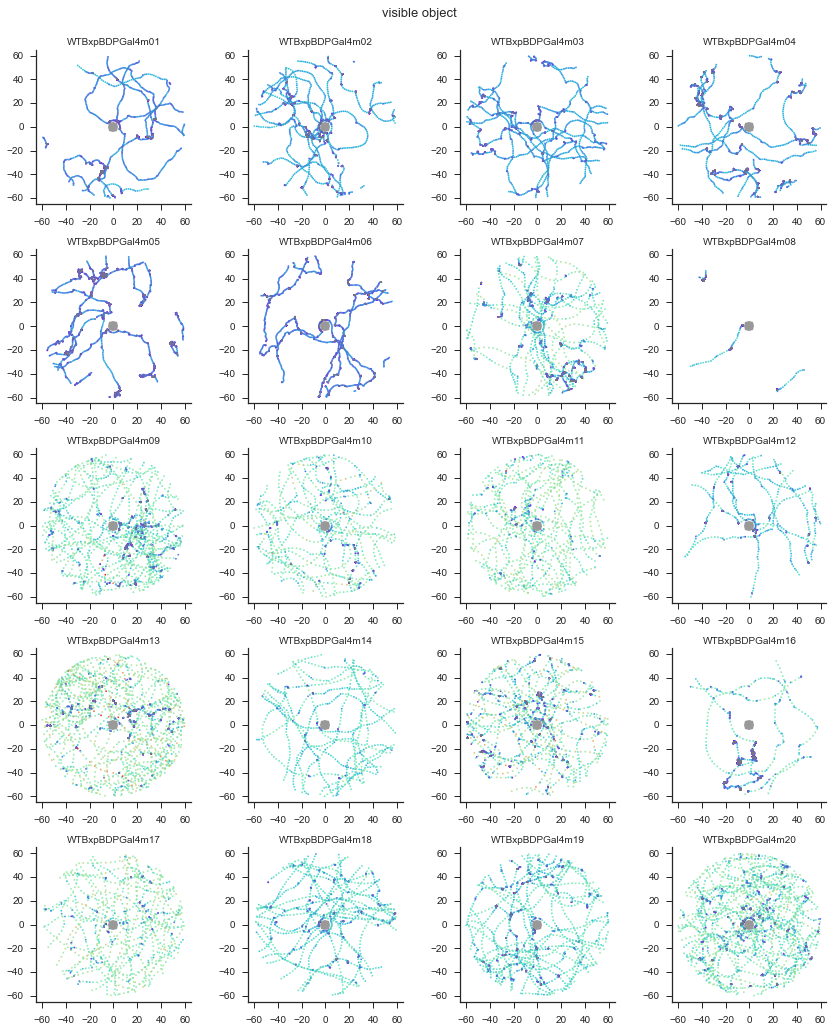

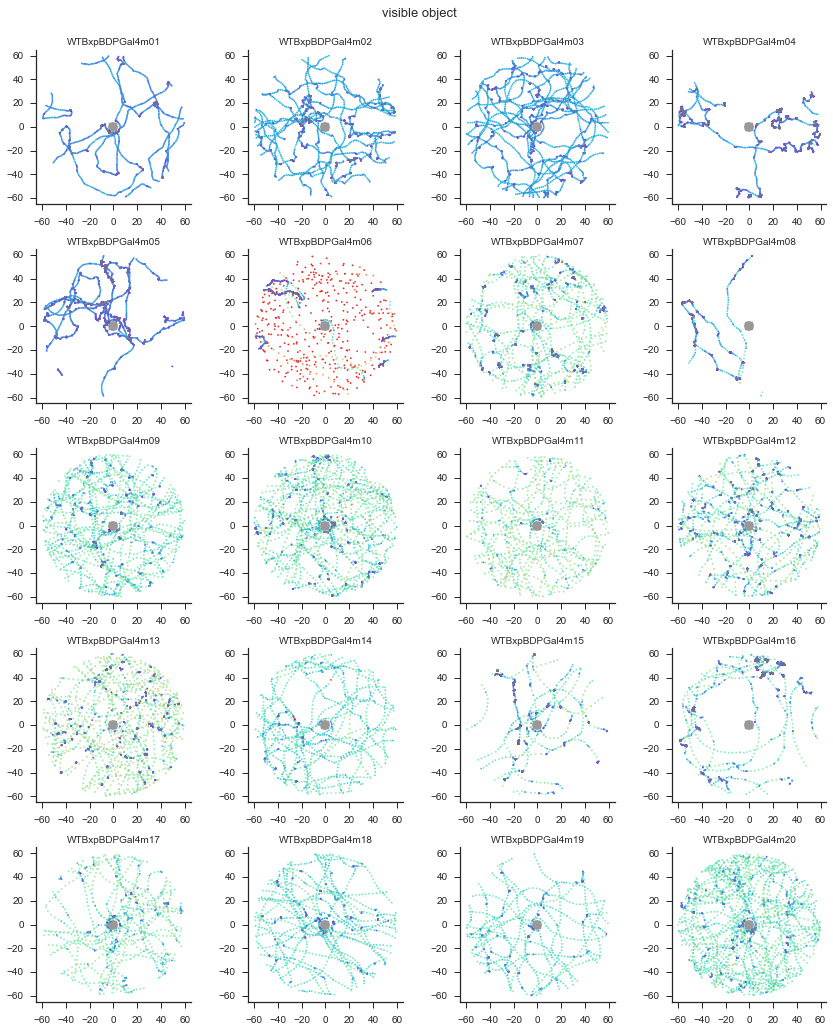

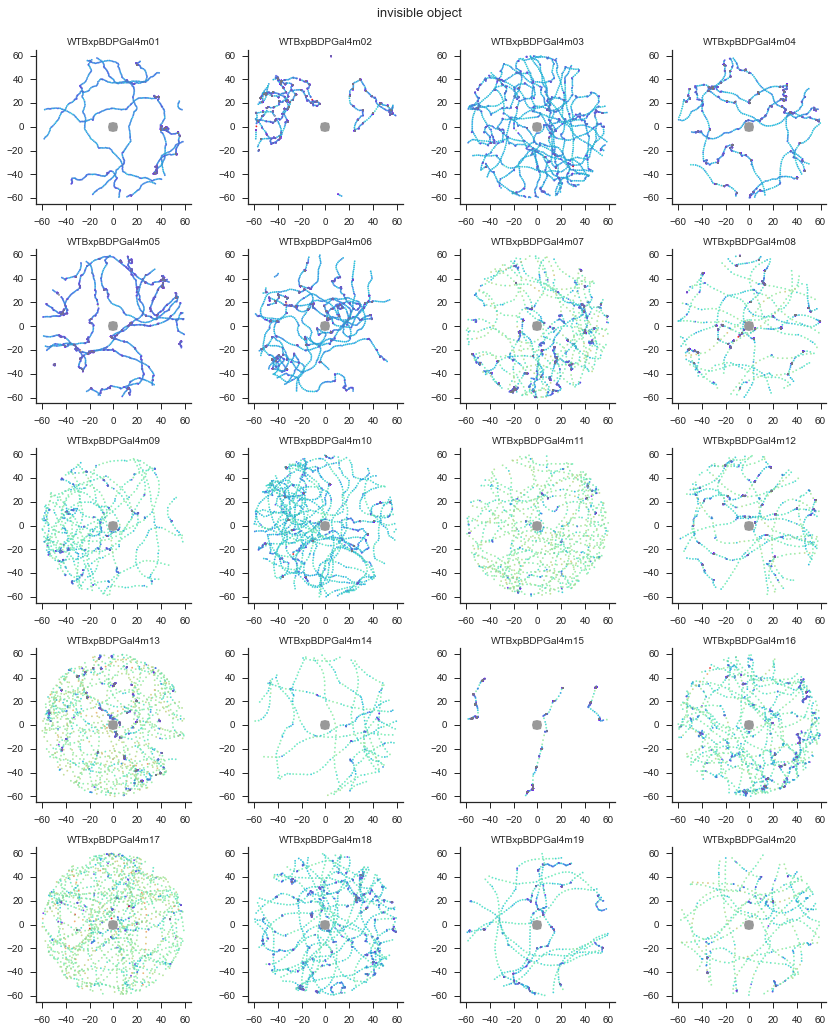

In [16]:
for ttind,trialtype in enumerate(visibilityState):
    multiflyTracePlot = plt.figure(figsize=(12,14))
    figtitle = multiflyTracePlot.suptitle(trialtype + ' object',fontsize=13,y=1.02)
    for fly in range(numFlies):
        multiflyTracePlot_sbplt = multiflyTracePlot.add_subplot(5,4,fly+1)
       
        querystring = '(trialtype=="' + trialtype + '") & (trial==' + str(ttind+1) + ') & (flyID =="' + flyIDs[fly] +  '")'

        perFlyX = FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1].squeeze()
        perFlyY = FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1].squeeze()
        perFlyvT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].squeeze()
        
        selectPts = range(0,len(perFlyX),4)
        #color = scalarMap.to_rgba(timecolor), alpha = 0.1)
        multiflyTracePlot_sbplt.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
        multiflyTracePlot_sbplt.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                        vmin=-1, vmax=35, edgecolor='none',alpha=0.9)
        multiflyTracePlot_sbplt.plot(0,0,'o',markersize=10, color='black', alpha=0.4)
        
        myAxisTheme(multiflyTracePlot_sbplt)
        multiflyTracePlot_sbplt.set_title(flyIDs[fly],fontsize=10)
        multiflyTracePlot_sbplt.set_aspect('equal')
        multiflyTracePlot_sbplt.set_xlim(-arenaRad-5, arenaRad + 5)
        multiflyTracePlot_sbplt.set_ylim(-arenaRad-5, arenaRad + 5)
        
    multiflyTracePlot.tight_layout()
    
    # analysisDir + 'tracePlotMA/' should already exist from single trial analysis
    # makeNestedPlotDirectory(analysisDir, 'tracePlotMA/', objecttype + sep)
    multiflyTracePlot.savefig(analysisDir + 'tracePlotMA/'  + genotypeSex + '_' + trialtype
                              + '_traceVeloColored_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf', 
                              bbox_extra_artists=(figtitle,), bbox_inches='tight')

## Velocity and relative heading distribution

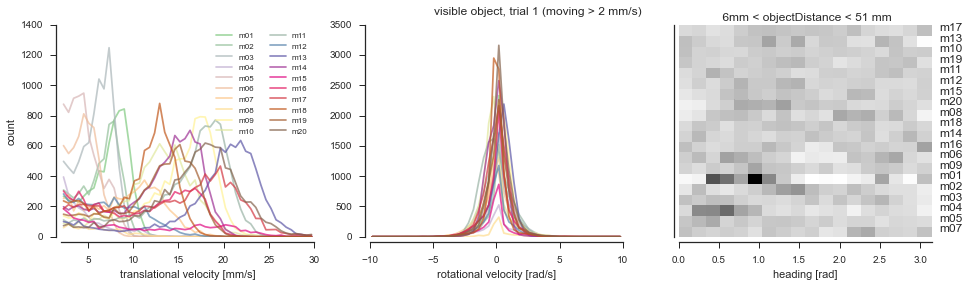

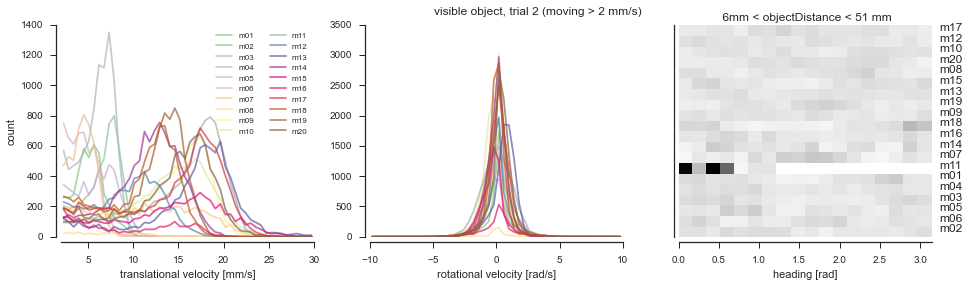

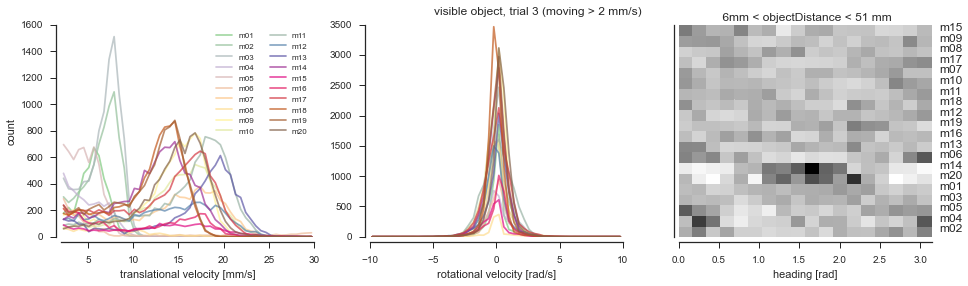

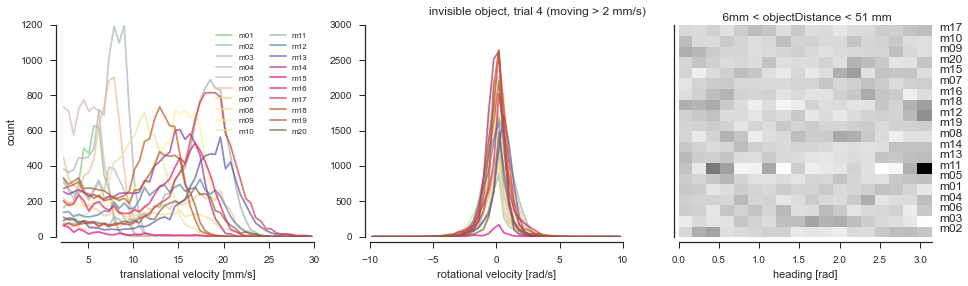

In [44]:
for ttind,trialtype in enumerate(visibilityState):
    
    veloDistFig = plotVeloHeadingDistribution_flyVR_df(FOAllFlies_df, trialtype, str(ttind+1), flyIDs, keylistLong, vTransTH)
    veloDistFig.tight_layout()
    
    veloDistFig.savefig(analysisDir + 'velocityTraces/'  + genotypeSex + '_' + trialtype
                        + '_veloDistributions_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

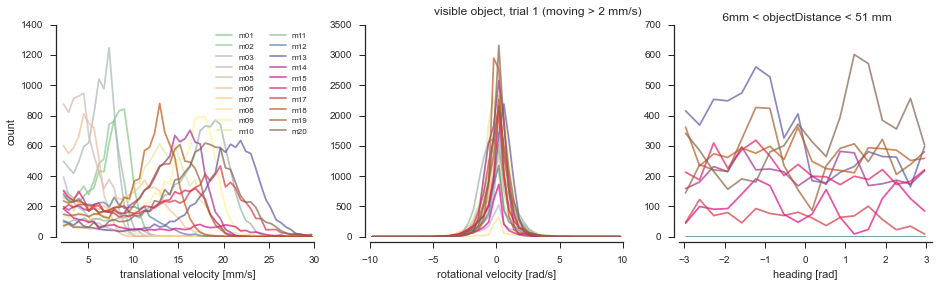

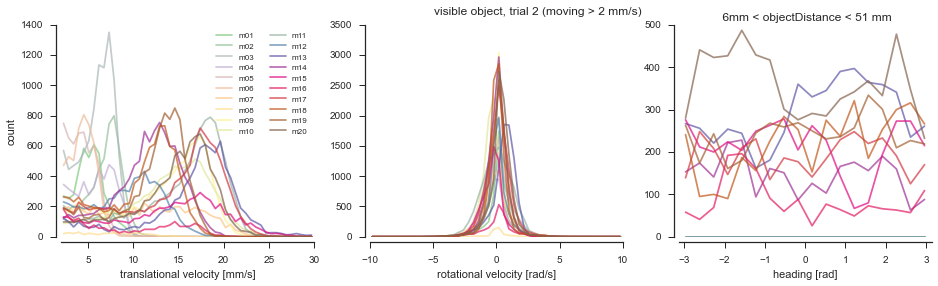

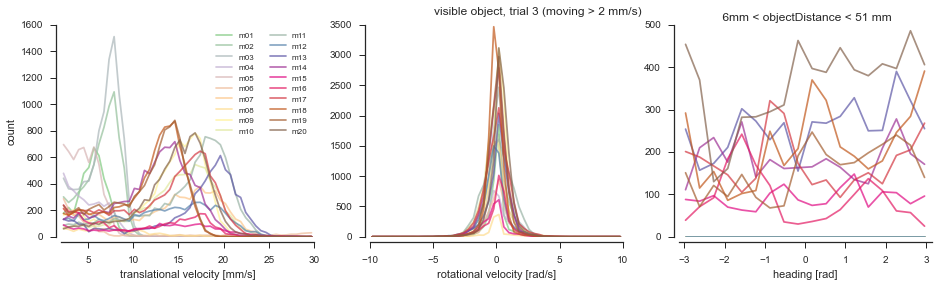

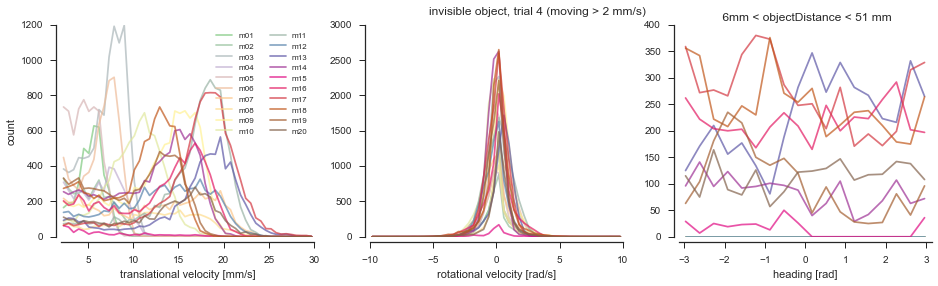

In [50]:
for ttind,trialtype in enumerate(visibilityState):
    
    veloDistFig = plotVeloHeadingDistribution2_flyVR_df(FOAllFlies_df, trialtype, str(ttind+1), flyIDs, keylistLong, vTransTH)
    veloDistFig.tight_layout()
    
    veloDistFig.savefig(analysisDir + 'velocityTraces/'  + genotypeSex + '_' + trialtype
                        + '_veloDistributions2_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

### TODO: extract peaks in per-fly heading distribution (maybe for several distances) 

## Residency plots

### 2D residency

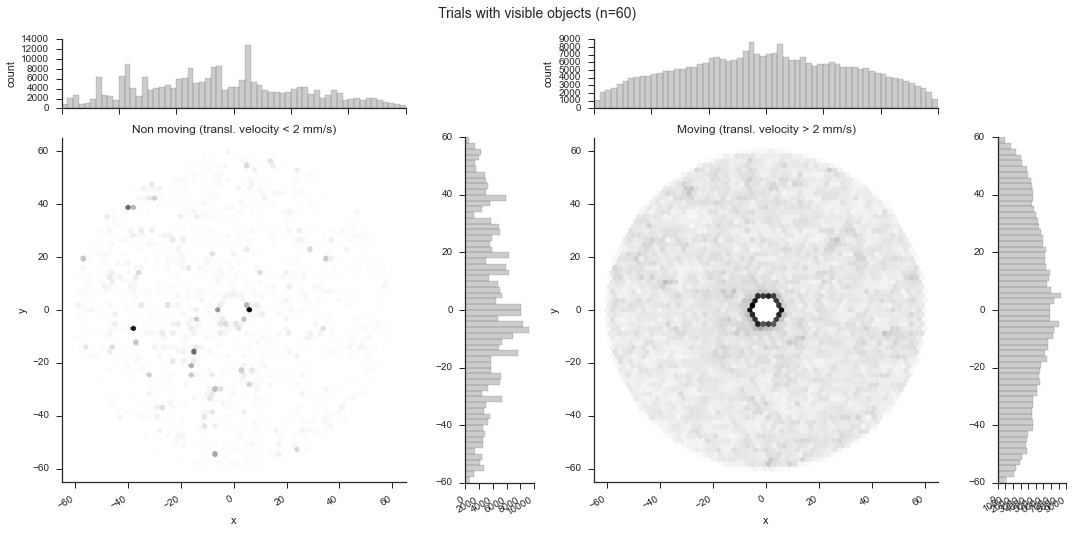

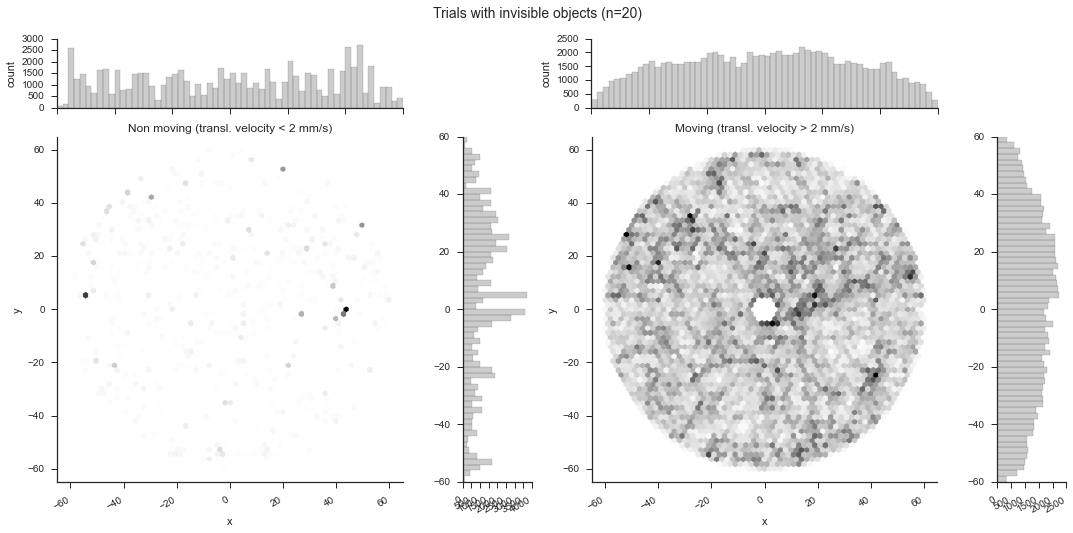

In [51]:
# make fly summary plot of residency:
arenaRad = 60
numBins = 60

keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_vT = keylistLong.index('transVelo')

nTrials = (nTrialsVI,nTrialsIN)

for indcond, condition in enumerate(['visible', 'invisible']):
    querystring = '(trialtype == "' + condition + '")'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    movingall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1]).squeeze().astype('bool')
    vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()

    movingall = vT>vTransTH

    # make plot
    noNans = ~np.isnan(xPosMAall)
    hexplotfig = residencyWithHistograms_splitOnWalking(
        xPosMAall[noNans], yPosMAall[noNans], movingall[noNans], arenaRad, numBins, vTransTH,
        'Trials with ' + condition + ' objects (n=' + str(nTrials[indcond]) + ')')
    
    #makeNestedPlotDirectory(analysisDir, 'velocityTraces/', objecttype + sep)
    # analysisDir + 'residencyPlots/' should already exist from single trial analysis
    hexplotfig.savefig(analysisDir + 'residencyPlots/'  + genotypeSex + '_' + condition
                        + '_residencyMA_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

### 1D resiceny (along readial distance from object)

Plot directory already exists


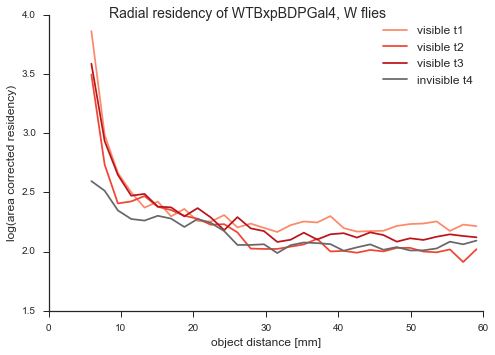

In [66]:
movementFilter = 'moving > 0'
numBins = 30
histRange = (5,arenaRad)

radResFig = plt.figure(figsize=(7,5))
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResPlt = radResFig.add_subplot(111)

radResPlt = oneDimResidency_df(radResPlt, FOAllFlies_df, keyind_xPos, keyind_yPos, movementFilter,
                               visibilityState, numBins, histRange,1)
myAxisTheme(radResPlt)
radResFig.tight_layout()

try:
    mkdir(analysisDir + 'residencyPlots/')
except:
    print('Plot directory already exists')
radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                    + '_radialResidency_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

### TODO: plot 1D residency as per-fly histogram for the 4 trials

## Distance vs. relative heading

#### 2D (polar) residency: heading vs. distance

In [72]:
def headingDistanceHistogram(headingDistHistSplt, objdistToPlot, gammaToPlot, distEdges, angleEdges):
    n, xedges, yedges = np.histogram2d(objdistToPlot, gammaToPlot, bins=(distEdges, angleEdges))

    X, Y = np.meshgrid(yedges, xedges)

    ringArea = (np.pi*xedges[1:]**2) - (np.pi*xedges[:-1]**2)
    ringArea2D = np.reshape(np.repeat(ringArea, (len(yedges)-1)), (len(xedges)-1, len(yedges)-1), order='C')

    headingDistHistSplt.pcolormesh(Y, X, n/ringArea2D)
    headingDistHistSplt.set_xlim(min(xedges), max(xedges))
    headingDistHistSplt.set_ylim(min(yedges), max(yedges))
    headingDistHistSplt.set_xlabel('radial distance from object [mm]')
    headingDistHistSplt.set_ylabel('angle relative to object [deg]')

    return headingDistHistSplt


def anglePerFlyHist(radHistSplt, flyIDs, gammaToPlot, flyIDallarray, angleEdges, angleBins):

    import matplotlib.colors as colors

    numFlies = len(flyIDs)
    flyCMap = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=numFlies), cmap='Accent')

    for fly in range(numFlies):
        n, edges = np.histogram(gammaToPlot[flyIDallarray == flyIDs[fly]],
                                range=(min(angleEdges), max(angleEdges)), bins=angleBins, normed=True)
        edgeCenteres = edges[:-1]+np.mean(np.diff(edges))/2.0

        radHistSplt.plot(n, edgeCenteres, color=flyCMap.to_rgba(fly))# , alpha=alphaVal)

    radHistSplt.set_xlabel('count')
    radHistSplt.set_ylim(min(angleEdges), max(angleEdges))

    return radHistSplt


def distancePerFlyHist(radHistSplt, flyIDs, objdistToPlot, flyIDallarray, distEdges, distBins):

    import matplotlib.colors as colors

    numFlies = len(flyIDs)
    flyCMap = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=numFlies), cmap='Accent')

    for fly in range(numFlies):
        n, edges = np.histogram(objdistToPlot[flyIDallarray == flyIDs[fly]],
                                range=(min(distEdges), max(distEdges)), bins=distBins, normed=True)
        edgeCenteres = edges[:-1]+np.mean(np.diff(edges))/2.0
        ringArea = (np.pi*edges[1:]**2) - (np.pi*edges[:-1]**2)

        radHistSplt.plot(edgeCenteres, n/ringArea, color=flyCMap.to_rgba(fly))# ,alpha=alphaVal)

    radHistSplt.set_ylabel('count (normed to area)')
    radHistSplt.set_xlim(min(distEdges), max(distEdges))
    flyIDsShort = []
    [flyIDsShort.append(flyIDs[fly][-3:]) for fly in range(numFlies)]
    radHistSplt.legend(flyIDsShort, ncol=4, loc='upper center', bbox_to_anchor=(0.85, 1), fontsize=8)

    return radHistSplt


def radDistAngleCombiPlot(distBins, angleBins, minDist, maxDist, flyIDs, flyIDarray, objDistance, gamma):

    distEdges = np.linspace(minDist, maxDist, distBins)
    angleEdges = np.linspace(-np.pi, np.pi, angleBins)

    gammaToPlot = gamma

    objdistToPlot = objDistance

    headingDistFig = plt.figure(figsize=(9, 6))
    gs = gridspec.GridSpec(2, 2, height_ratios=(1, 3), width_ratios=(3, 1))

    # Subplot1: per fly distance histogram
    radHistSplt = headingDistFig.add_subplot(gs[0])
    radHistSplt = distancePerFlyHist(radHistSplt, flyIDs, objdistToPlot, flyIDarray, distEdges, distBins)
    myAxisTheme(radHistSplt)

    # Subplot2:  2d distance/angle histogram
    headingDistHistSplt = headingDistFig.add_subplot(gs[2])
    headingDistHistSplt = headingDistanceHistogram(headingDistHistSplt, objdistToPlot, gammaToPlot, distEdges, angleEdges)
    myAxisTheme(headingDistHistSplt)

    # Subplot3: per fly angle histogram
    radHistSplt = headingDistFig.add_subplot(gs[3])
    radHistSplt = anglePerFlyHist(radHistSplt, flyIDs, gammaToPlot, flyIDarray, angleEdges, angleBins)
    myAxisTheme(radHistSplt)

    headingDistFig.tight_layout()

    return headingDistFig

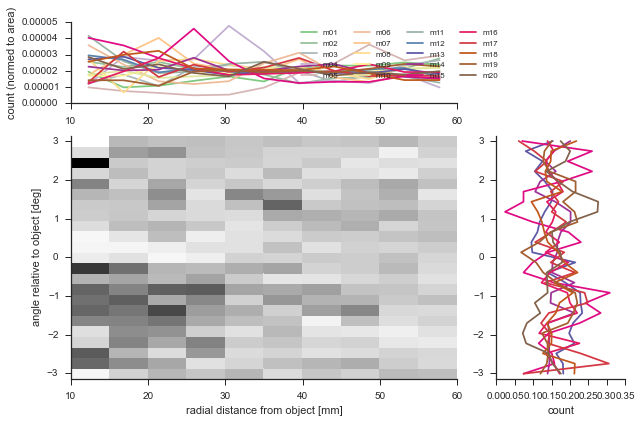

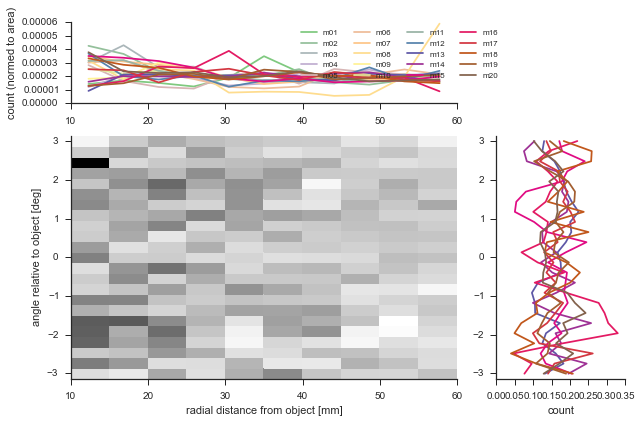

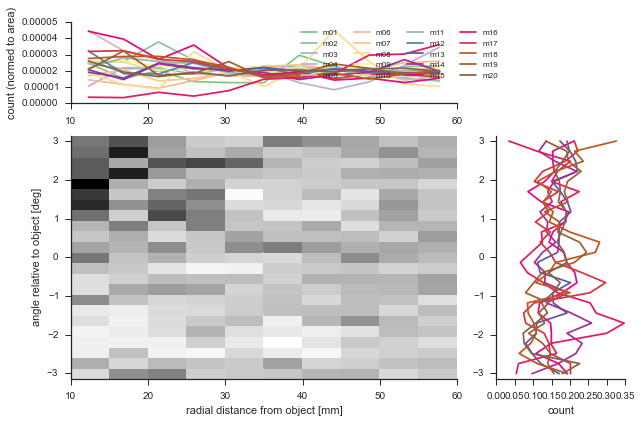

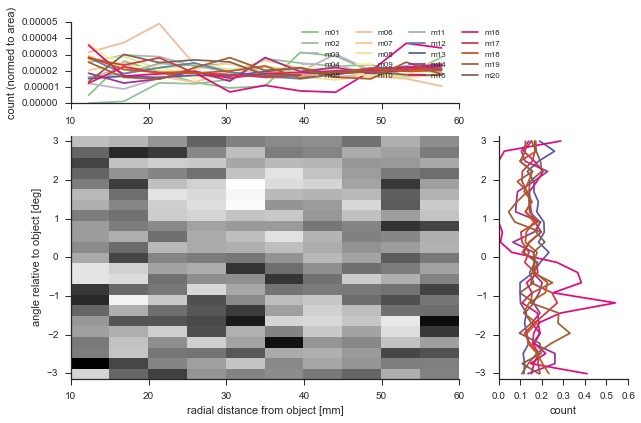

In [73]:
# plot parameter
distBins = 11
angleBins = 24
maxDist = arenaRad
minDist = 10

# Note: Line plot alphas are proportional to amount of data the respective fly contrinuted
for ttind,trialtype in enumerate(visibilityState):
    querystring = '(trialtype == "'+trialtype+'") & (trial == '+str(ttind+1)+\
        ') & (moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<' + str(maxDist) + ')'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
    flyIDallarray = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_fly:keyind_fly+1]).squeeze()
    
    objDistMAall, _ = cartesian2polar(xPosMAall,yPosMAall)

    headingDistFig = radDistAngleCombiPlot(distBins,angleBins,minDist,maxDist,flyIDs,flyIDallarray,
                                           objDistMAall,gammaFullall)
    
    headingDistFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
                           + '_headingVsDistanceHist_trial'+ str(ttind+1) +'_n'+ str(len(flyIDs)) +'.pdf',
                           format='pdf')

## Analysis of steering maneuvres and their relationship with the object location

### Turnrate relative to object distance

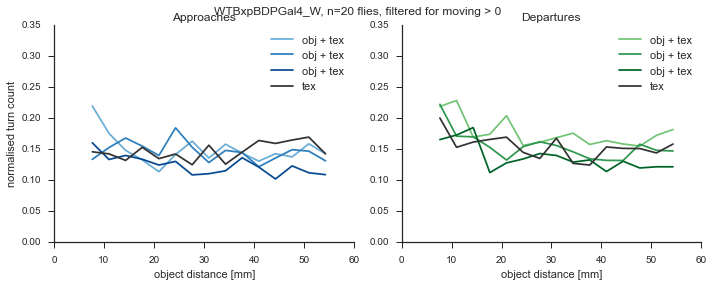

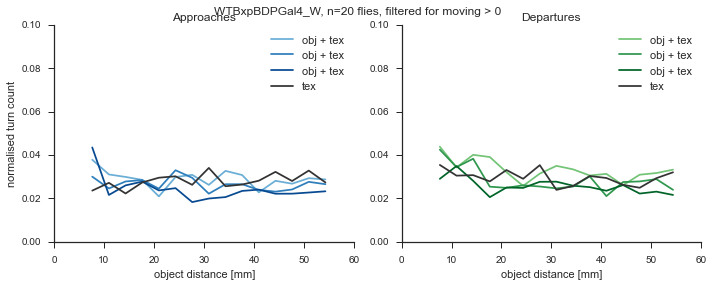

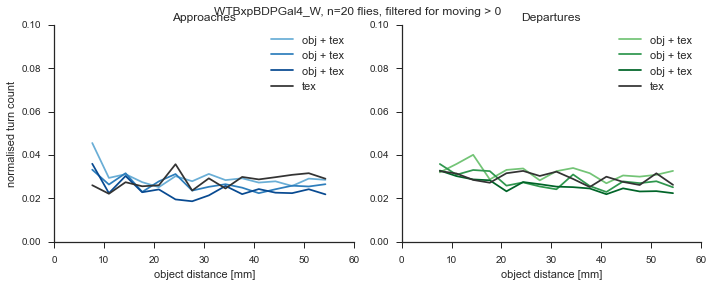

In [75]:
numBins = 15#10
useTurnIndex = False
movementFilter='moving > 0'

try:
    mkdir(analysisDir + 'turnRates/')
except:
    print('Plot directory already exists')

useTurnChange = 0

Fig = plt.figure(figsize=(10,4))
Fig.suptitle(genotype +'_'+flyIDs[0][0]+', n='+str(numFlies)+' flies, filtered for '+movementFilter , fontsize=12)
yLimRange = (0,0.35)
Fig = turnRatePerDistance(Fig,FOAllFlies_df,keylistLong,visibilityState,movementFilter,useTurnIndex,
                          useTurnChange,trialName,yLimRange,numBins,arenaRad)

#Fig.savefig(analysisDir + 'turnRates/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
#            + '_turnRatePerDistance_aboveTH'+'_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

useTurnChange = 1

Fig = plt.figure(figsize=(10,4))
Fig.suptitle(genotype +'_'+flyIDs[0][0]+', n='+str(numFlies)+' flies, filtered for '+movementFilter , fontsize=12)
yLimRange = (0,0.1)
Fig = turnRatePerDistance(Fig,FOAllFlies_df,keylistLong,visibilityState,movementFilter,useTurnIndex,
                          useTurnChange,trialName,yLimRange,numBins,arenaRad)

#Fig.savefig(analysisDir + 'turnRates/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
#            + '_turnRatePerDistance_turnStart'+'_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

useTurnChange = -1

Fig = plt.figure(figsize=(10,4))
Fig.suptitle(genotype +'_'+flyIDs[0][0]+', n='+str(numFlies)+' flies, filtered for '+movementFilter , fontsize=12)
yLimRange = (0,0.1)
Fig = turnRatePerDistance(Fig,FOAllFlies_df,keylistLong,visibilityState,movementFilter,useTurnIndex,
                          useTurnChange,trialName,yLimRange,numBins,arenaRad)

#Fig.savefig(analysisDir + 'turnRates/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
#            + '_turnRatePerDistance_turnEnd'+'_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

## Polar coord maps of movement parameter

In [80]:
def relPolarCoordAverageMap(relPolMeanPlt, distEdges, angleEdges, valuesToMap, 
                            objDistance, gamma, colorMap,useMean, maxValue, xlab, ylab):
    
    # bin valuesToMap by objectDistance value
    digitizedDist = np.digitize(objDistance, distEdges)

    # bin valuesToMap by objectDistance value
    digitizedAngle = np.digitize(gamma, angleEdges)

    meanVals = 1.0*np.zeros((len(angleEdges),len(distEdges)))

    for distBin in range(1, 1+len(distEdges)):
        for angleBin in range(1, 1+len(angleEdges)):
            sltPts = np.logical_and(digitizedDist==distBin, digitizedAngle==angleBin)
            if sum(sltPts) > 0:
                if useMean:
                    meanVals[angleBin-1,distBin-1,] = np.mean(valuesToMap[sltPts])
                else: #use median
                    meanVals[angleBin-1,distBin-1,] = np.median(valuesToMap[sltPts])
    
    #maxValue = np.max(np.abs(meanVals))
    pc = relPolMeanPlt.pcolormesh(distEdges, angleEdges, meanVals, cmap = colorMap, vmin=-maxValue, vmax=maxValue)
    relPolMeanPlt.set_xlim(min(distEdges), max(distEdges))
    relPolMeanPlt.set_ylim(min(angleEdges), max(angleEdges))
    relPolMeanPlt.set_xlabel(xlab)
    relPolMeanPlt.set_ylabel(ylab)

    return relPolMeanPlt, meanVals, pc


def movementSplitPolarAverageMaps(relPolMeanPltAll,relPolMeanPltAp,relPolMeanPltDep,cbax,titleString,distEdges,angleEdges,app,
                                  dep,valuesToMap,objDistance,gamma,useMean,maxValue):
   
    cMap = 'RdBu'
    relPolMeanPltAp.set_title('Total')
    relPolMeanPltAll, meanVals, pc = relPolarCoordAverageMap(relPolMeanPltAll,distEdges,angleEdges,
                    valuesToMap,objDistance,gamma,cMap,useMean,maxValue,
                    'radial distance from object [mm]','heading angle relative to object [deg]')
    myAxisTheme(relPolMeanPltAll)
    
    relPolMeanPltAp.set_title('Approaches')
    relPolMeanPltAp, meanVals, pc = relPolarCoordAverageMap(relPolMeanPltAp, distEdges,angleEdges,
                    valuesToMap[app],objDistance[app],gamma[app],cMap,useMean,maxValue,
                    'radial distance from object [mm]','')
    myAxisTheme(relPolMeanPltAp)


    relPolMeanPltDep.set_title('Departures')
    relPolMeanPltDep, meanVals, pc = relPolarCoordAverageMap(relPolMeanPltDep, distEdges,angleEdges,
                    valuesToMap[dep], objDistance[dep],gamma[dep],cMap,useMean,maxValue,
                    'radial distance from object [mm]','')
    cb = plt.colorbar(pc, cax = cbax)
    cb.ax.set_ylabel(titleString,rotation=270,fontsize=12)
    myAxisTheme(relPolMeanPltDep)
    
    return relPolMeanPltAp,relPolMeanPltDep


def make4ValuePolCoordPlot(relPolMeanFig, querystring,maxVals):
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    gammaall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
    gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
    vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
    time = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()

    # Transform trajectory to polar coordinates
    objDistanceall, thetaall = cartesian2polar(xPosMAall,yPosMAall)
    d_objDist = np.hstack((0, np.diff(np.convolve(objDistanceall, np.ones((7,))/7, mode='same'))))

    # Split data roughly into 'approaches' and 'departues'
    app = d_objDist<0 #np.logical_and(d_objDist<0,gammaall<=1.25*np.pi/2.0)
    dep = d_objDist>0 #np.logical_and(d_objDist>0,gammaall>0.75*np.pi/2.0)
    useMean = False

    gs = gridspec.GridSpec(5,4,width_ratios=[1,1,1,0.05])

    # 1) Translational velocity
    titleString = 'Median translational velocity'
    _ = movementSplitPolarAverageMaps(relPolMeanFig.add_subplot(gs[0]),relPolMeanFig.add_subplot(gs[1]),
                                      relPolMeanFig.add_subplot(gs[2]),relPolMeanFig.add_subplot(gs[3]),titleString,
                                      distEdges,fullAngleEdges,app,dep,vT,objDistanceall,gammaFullall,useMean,maxVals[0])
    
    # 2) Translational acceleration
    d_vT = np.hstack((0, np.diff(np.convolve(vT, np.ones((5,))/5, mode='same'))/np.diff(time)))
    d_vT = np.convolve(d_vT, np.ones((5,))/5, mode='same')
    d_vT[abs(d_vT)>2*np.std(abs(d_vT))] = np.sign(d_vT[abs(d_vT)>2*np.std(abs(d_vT))])*2*np.std(abs(d_vT))

    titleString = 'Median translational acceleration'
    _ = movementSplitPolarAverageMaps(relPolMeanFig.add_subplot(gs[4]),relPolMeanFig.add_subplot(gs[5]),
                                      relPolMeanFig.add_subplot(gs[6]),relPolMeanFig.add_subplot(gs[7]),titleString,
                                      distEdges,fullAngleEdges,app,dep,d_vT,objDistanceall,gammaFullall,useMean,maxVals[1])

    # 3) Heading angle change
    d_gamma = np.hstack((0, np.diff(gammaall)/np.diff(time)))
    d_gamma = np.convolve(d_gamma, np.ones((7,))/7, mode='same')
    titleString = 'Median heading velocity'
    _ = movementSplitPolarAverageMaps(relPolMeanFig.add_subplot(gs[8]),relPolMeanFig.add_subplot(gs[9]),
                                      relPolMeanFig.add_subplot(gs[10]),relPolMeanFig.add_subplot(gs[11]),titleString,
                                      distEdges,fullAngleEdges,app,dep,d_gamma,objDistanceall,gammaFullall,useMean,maxVals[2])

    # 4) Corrected curvature
    polarCurv, d_theta, dtheta_objDist = polarCurvature(thetaall,objDistanceall)
    turnSign = np.sign(polarCurv)
    turnSign[d_theta>0] = np.sign(polarCurv[d_theta>0])
    turnSign[d_theta<0] = -np.sign(polarCurv[d_theta<0])
    polarCurv = np.convolve(polarCurv, np.ones((5,))/5, mode='same')
    polarCurv[abs(polarCurv)>2] = 2*np.sign(polarCurv[abs(polarCurv)>2])
    curvmag = abs(np.convolve(polarCurv, np.ones((5,))/5, mode='same'))
    corCurv = turnSign*curvmag

    titleString = 'Median (corrected) curvature'
    _ = movementSplitPolarAverageMaps(relPolMeanFig.add_subplot(gs[12]),relPolMeanFig.add_subplot(gs[13]),
                                      relPolMeanFig.add_subplot(gs[14]),relPolMeanFig.add_subplot(gs[15]),titleString,
                                      distEdges,fullAngleEdges,app,dep,corCurv,objDistanceall,gammaFullall,useMean,maxVals[3])
    
    
    # 5) Coverage map
    titleString = 'Sampling coverage'
    nAll,xedAll,yedAll = np.histogram2d(objDistanceall,gammaFullall,bins=(distEdges,fullAngleEdges))
    nApr,xedApr,yedApr = np.histogram2d(objDistanceall[app],gammaFullall[app],bins=(distEdges,fullAngleEdges))
    nDep,xedDep,yedDep = np.histogram2d(objDistanceall[dep],gammaFullall[dep],bins=(distEdges,fullAngleEdges))
    
    allCov = relPolMeanFig.add_subplot(gs[16])
    X,Y = np.meshgrid(yedAll,xedAll)
    allCov.pcolormesh(Y,X,nAll,cmap='copper_r',vmin=0,vmax=np.max(nAll))
    allCov.set_ylim(min(yedAll),max(yedAll))
    allCov.set_xlim(min(xedAll),max(xedAll))
    allCov.set_title('Approaches')
    allCov.set_xlabel('radial distance from object [mm]')
    allCov.set_ylabel('heading angle relative to object [deg]')
    myAxisTheme(allCov)
    
    aprCov = relPolMeanFig.add_subplot(gs[17])
    X,Y = np.meshgrid(yedApr,xedApr)
    aprCov.pcolormesh(Y,X,nApr,cmap='copper_r',vmin=0,vmax=np.max(nAll))#max(np.max(nApr),np.max(nDep)))
    aprCov.set_ylim(min(yedApr),max(yedApr))
    aprCov.set_xlim(min(xedApr),max(xedApr))
    aprCov.set_title('Approaches')
    aprCov.set_xlabel('radial distance from object [mm]')
    myAxisTheme(aprCov)
    
    depCov = relPolMeanFig.add_subplot(gs[18])
    X,Y = np.meshgrid(yedDep,xedDep)
    pc = depCov.pcolormesh(Y,X,nDep,cmap='copper_r',vmin=0,vmax=np.max(nAll))#max(np.max(nApr),np.max(nDep)))
    depCov.set_ylim(min(yedDep),max(yedDep))
    depCov.set_xlim(min(xedDep),max(xedDep))
    depCov.set_title('Departures')
    aprCov.set_xlabel('radial distance from object [mm]')
    myAxisTheme(depCov)
    
    cb = plt.colorbar(pc, cax = relPolMeanFig.add_subplot(gs[19]))
    cb.ax.set_ylabel(titleString,rotation=270,fontsize=12)
    
    return relPolMeanFig

In [81]:
minDist = 6
maxDist = 56
distEdges = np.linspace(minDist, maxDist, 10)
angleEdges = np.linspace(0, np.pi, 9)
fullAngleEdges = np.linspace(-np.pi, np.pi, 36)

maxVals = (20.0,10.0, 1.5, 0.3)#(12.0,7.0, 1.0, 0.3)

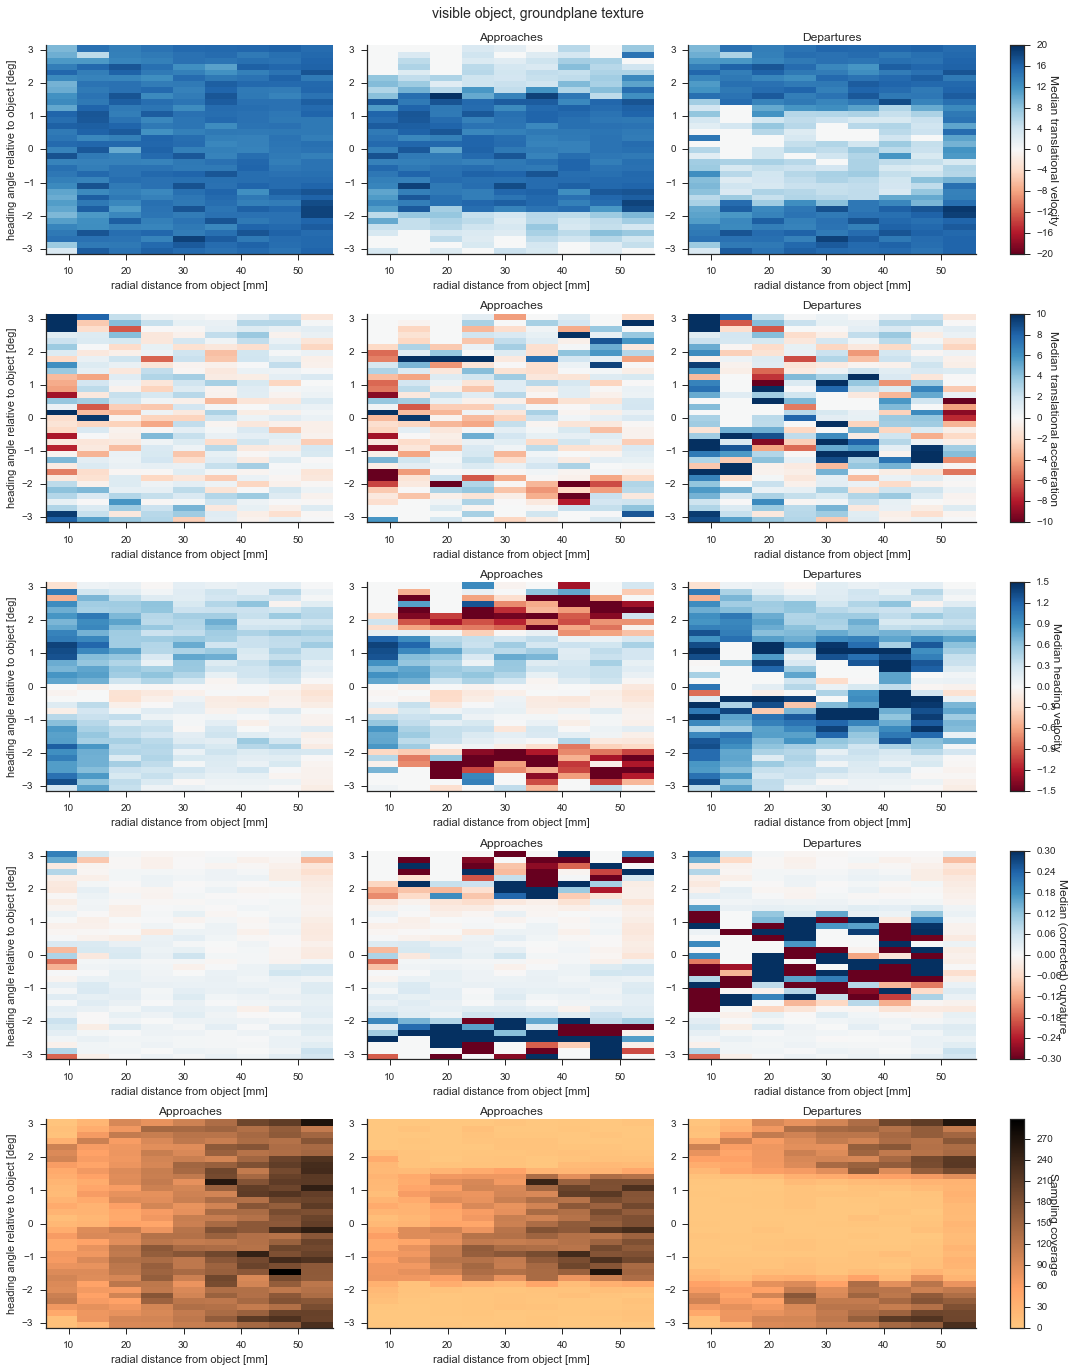

In [83]:
trialtype = 'visible'
trial = 1

querystring = '(moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+\
                ') & (trialtype == "'+ trialtype +'") & (trial == '+str(trial)+')' 

relPolMeanFig = plt.figure(figsize = (15,20))
relPolMeanFig = make4ValuePolCoordPlot(relPolMeanFig,FOAllFlies_df,querystring,maxVals)
relPolMeanFig.tight_layout()
relPolMeanFig.tight_layout(rect=[0, 0.03, 1, 0.97])
relPolMeanFig.suptitle(trialtype + ' object, groundplane ' + groundPlane[trial-1],fontsize=14)

relPolMeanFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
                      + '_steering_headingVsDistance_trial'+ str(trial) +'_n'+ str(len(flyIDs)) +'.pdf',
                      format='pdf')

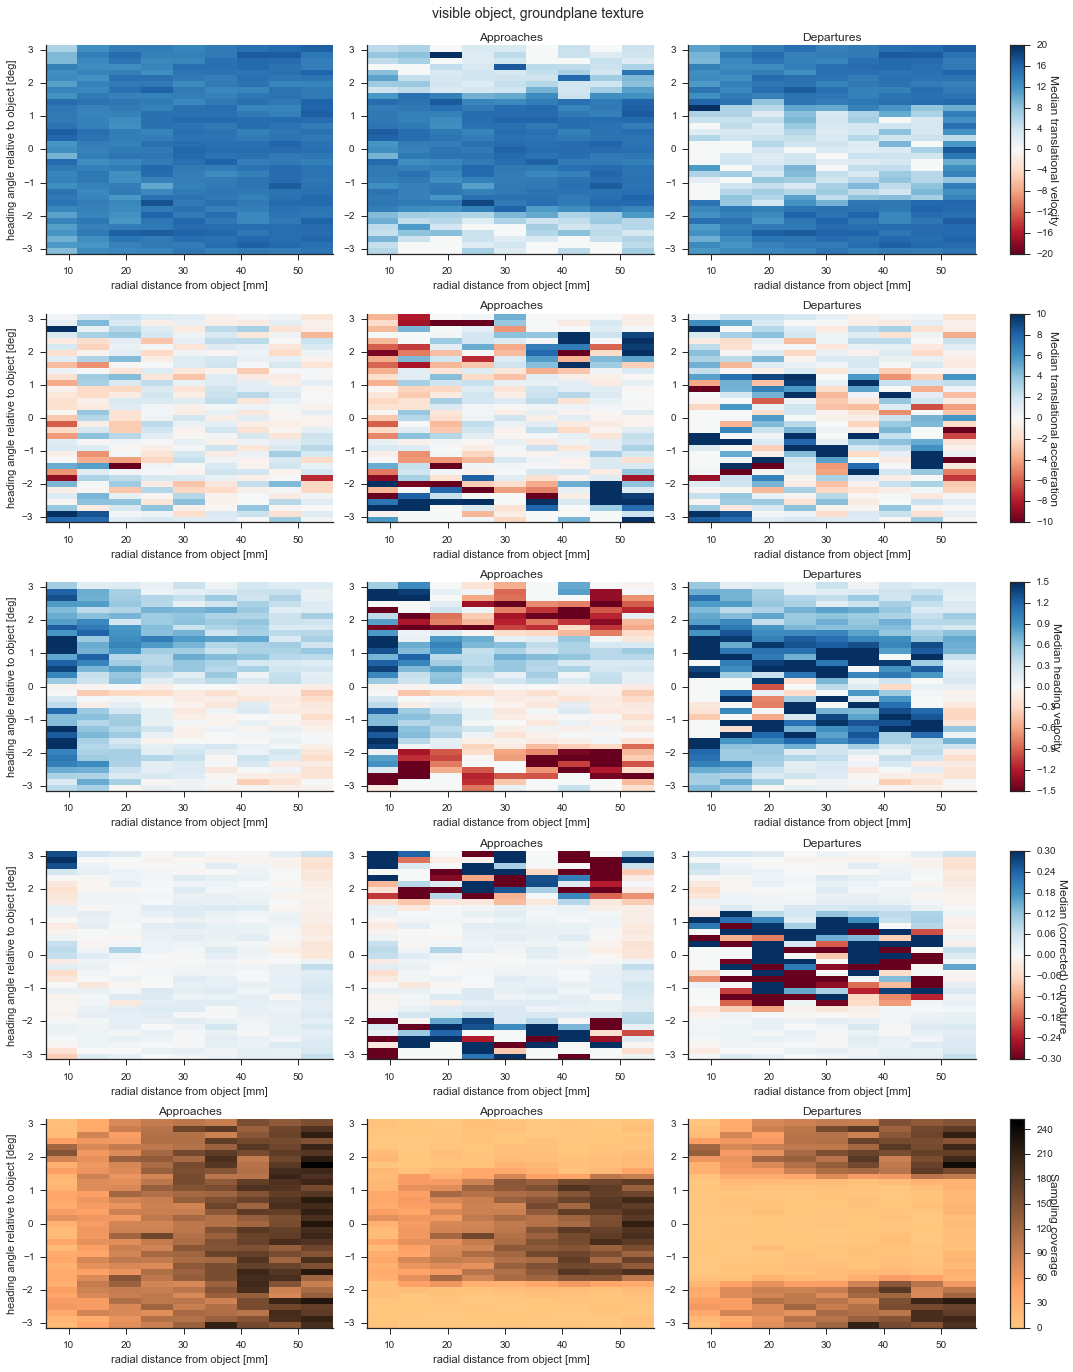

In [84]:
trialtype = 'visible'
trial = 2

querystring = '(moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+\
                ') & (trialtype == "'+ trialtype +'") & (trial == '+str(trial)+')' 

relPolMeanFig = plt.figure(figsize = (15,20))
relPolMeanFig = make4ValuePolCoordPlot(relPolMeanFig,querystring,maxVals)
relPolMeanFig.tight_layout()
relPolMeanFig.tight_layout(rect=[0, 0.03, 1, 0.97])
relPolMeanFig.suptitle(trialtype + ' object, groundplane ' + groundPlane[trial-1],fontsize=14)

relPolMeanFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
                      + '_steering_headingVsDistance_trial'+ str(trial) +'_n'+ str(len(flyIDs)) +'.pdf',
                      format='pdf')

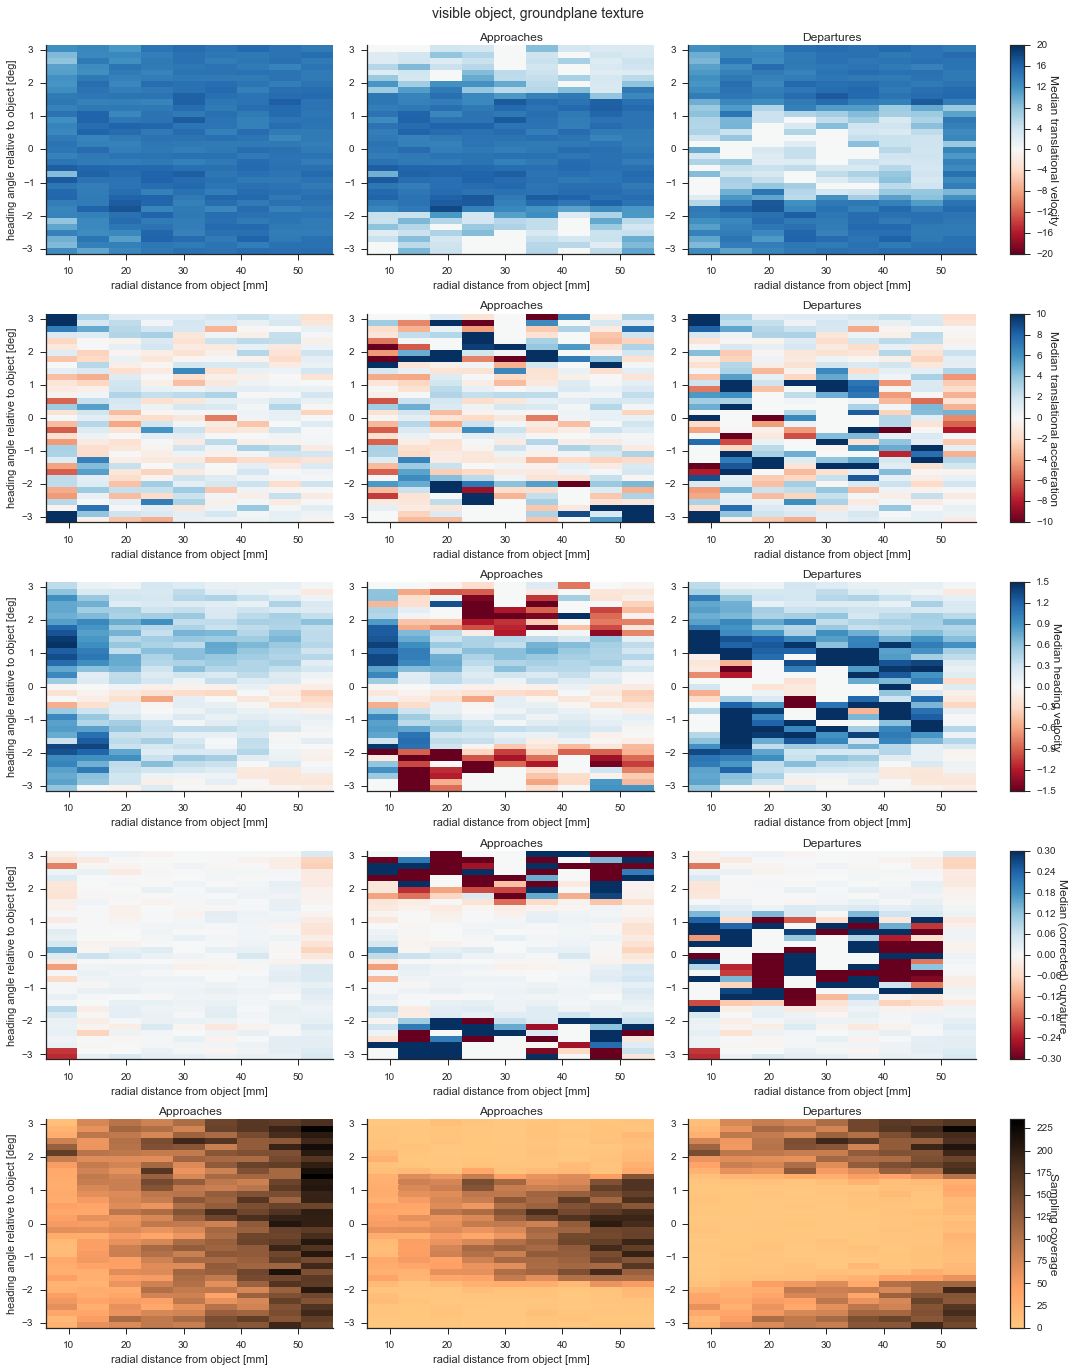

In [85]:
trialtype = 'visible'
trial = 3

querystring = '(moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+\
                ') & (trialtype == "'+ trialtype +'") & (trial == '+str(trial)+')' 

relPolMeanFig = plt.figure(figsize = (15,20))
relPolMeanFig = make4ValuePolCoordPlot(relPolMeanFig,querystring,maxVals)
relPolMeanFig.tight_layout()
relPolMeanFig.tight_layout(rect=[0, 0.03, 1, 0.97])
relPolMeanFig.suptitle(trialtype + ' object, groundplane ' + groundPlane[trial-1],fontsize=14)

relPolMeanFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
                      + '_steering_headingVsDistance_trial'+ str(trial) +'_n'+ str(len(flyIDs)) +'.pdf',
                      format='pdf')

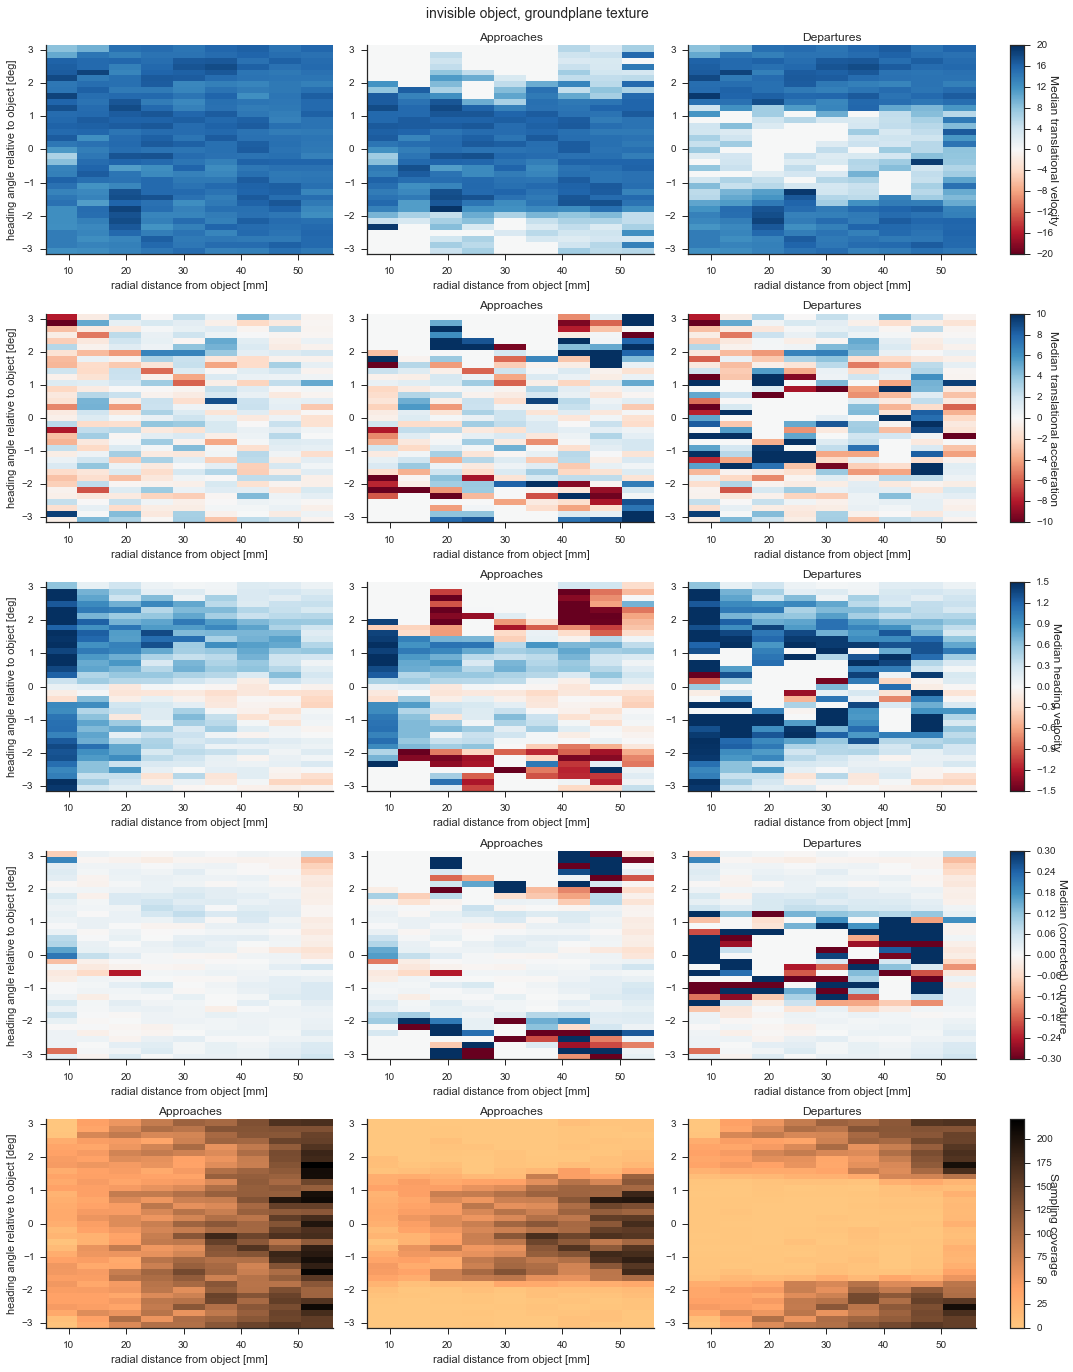

In [86]:
trialtype = 'invisible'
trial = 4

querystring = '(moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+\
                ') & (trialtype == "'+ trialtype +'") & (trial == '+str(trial)+')' 

relPolMeanFig = plt.figure(figsize = (15,20))
relPolMeanFig = make4ValuePolCoordPlot(relPolMeanFig,querystring,maxVals)
relPolMeanFig.tight_layout()
relPolMeanFig.tight_layout(rect=[0, 0.03, 1, 0.97])
relPolMeanFig.suptitle(trialtype + ' object, groundplane ' + groundPlane[trial-1],fontsize=14)

relPolMeanFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
                      + '_steering_headingVsDistance_trial'+ str(trial) +'_n'+ str(len(flyIDs)) +'.pdf',
                      format='pdf')

## Comparison between trials

Analysis directory already exists.


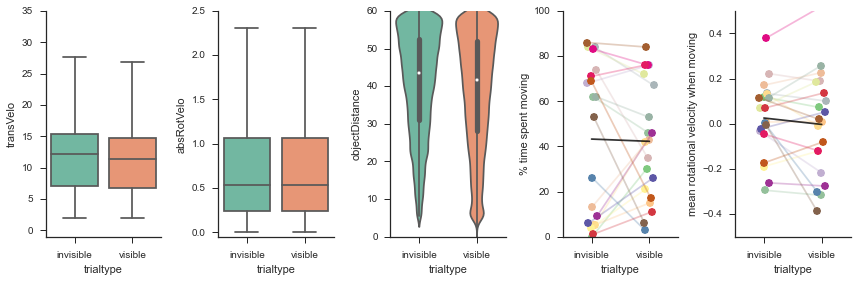

In [250]:
FOAllFliesMoving_df = FOAllFlies_df.query('(moving > 0)')
FOAllFliesMoving_df = FOAllFliesMoving_df[keylistLong]
FOAllFliesMoving_df.insert(0, 'absRotVelo', abs(FOAllFliesMoving_df['rotVelo']))

perTrialBP = plt.figure(figsize=(12,4))

perTrialBPvT = perTrialBP.add_subplot(151)
sns.boxplot(x='trialtype', y='transVelo', 
            data=FOAllFliesMoving_df, palette='Set2',sym='')
perTrialBPvT.set_ylim(-1,35)
myAxisTheme(perTrialBPvT)

perTrialBPvR = perTrialBP.add_subplot(152)
sns.boxplot(x='trialtype', y='absRotVelo',
            data=FOAllFliesMoving_df, palette='Set2',sym='')
perTrialBPvR.set_ylim(-0.05,2.5)
myAxisTheme(perTrialBPvR)

perTrialVPod = perTrialBP.add_subplot(153)
sns.violinplot(x='trialtype', y='objectDistance', data=FOAllFliesMoving_df,
               palette='Set2',sym='', bw=.1)
               #,inner='stick',  scale='count')
perTrialVPod.set_ylim(0,arenaRad)
myAxisTheme(perTrialVPod)

percentMoving = np.zeros((numFlies,2))
rotationBias = np.zeros((numFlies,2))
randJitter = np.zeros((numFlies,2))

perFlyMovingPlt = perTrialBP.add_subplot(154)
plt.xticks([1,2], ["invisible","visible"], rotation='horizontal')
perFlyRotBiasPlt = perTrialBP.add_subplot(155)
plt.xticks([1,2], ["invisible","visible"], rotation='horizontal')

for fly in range(numFlies):
    for ttind,trialtype in enumerate(["invisible","visible"]):
        querystring = '(trialtype == "' + trialtype + '") & (flyID == "' + flyIDs[fly] +  '")'
        perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('bool')
        perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float')        
        jitter = np.random.uniform(-0.1, 0.1)
        percentMoving[fly,ttind] = 100*sum(perFlyMoving)/max(1,len(perFlyMoving))
        rotationBias[fly,ttind] = np.mean(perFlyRot[perFlyMoving])
        randJitter[fly,ttind] = jitter
        perFlyMovingPlt.plot(ttind+1+jitter,percentMoving[fly,ttind],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        perFlyRotBiasPlt.plot(ttind+1+jitter,rotationBias[fly,ttind],'.',
                              markersize=15,color = flyCMap.to_rgba(fly))

    perFlyMovingPlt.plot(range(1,3)+randJitter[fly,:] ,percentMoving[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    perFlyRotBiasPlt.plot(range(1,3)+randJitter[fly,:] ,rotationBias[fly,:],'-',
                          markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
#plot average response
perFlyMovingPlt.plot(range(1,3),np.mean(percentMoving,axis=0),color='k',alpha=0.8)
perFlyRotBiasPlt.plot(range(1,3),np.mean(rotationBias,axis=0),color='k',alpha=0.8)

perFlyMovingPlt.set_ylim(0,100)
perFlyMovingPlt.set_xlim(0.5,2.5)
perFlyMovingPlt.set_xlabel('trialtype')
perFlyMovingPlt.set_ylabel('% time spent moving')
myAxisTheme(perFlyMovingPlt)

perFlyRotBiasPlt.set_ylim(-0.5,0.5)
perFlyRotBiasPlt.set_xlim(0.5,2.5)
perFlyRotBiasPlt.set_xlabel('trialtype')
perFlyRotBiasPlt.set_ylabel('mean rotational velocity when moving')
myAxisTheme(perFlyRotBiasPlt)

perTrialBP.tight_layout()

try:
    mkdir(analysisDir + sep + 'compareTrialtypes' + sep)
except OSError:
    print('Analysis directory already exists.')

perTrialBP.savefig(analysisDir + 'compareTrialtypes/'  + genotypeSex
                   + '_visibleVSinvisible_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

### TODO: Change plot
#### --> merge residency plots into one 1D plot with all trials
#### --> plot per-fly mean distance

Analysis directory already exists.


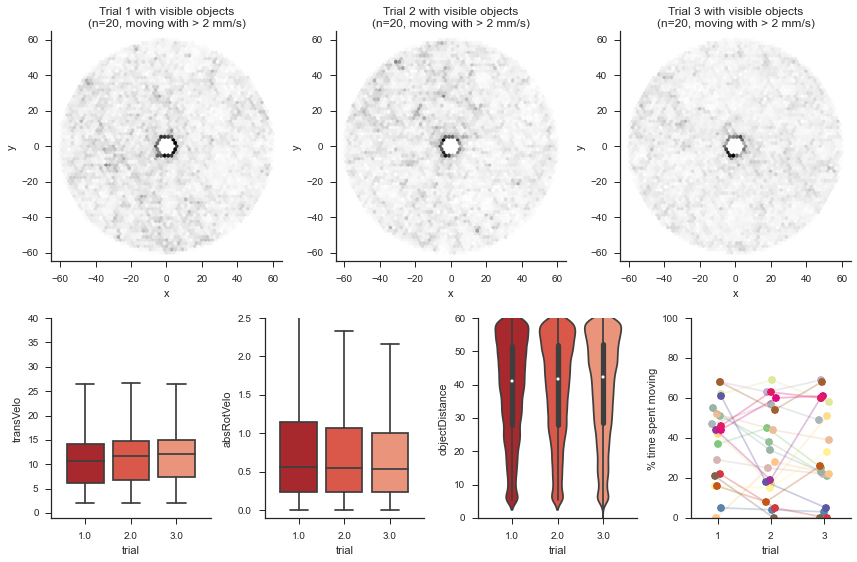

In [251]:
# make fly summary plot of residency:
arenaRad = 60
numBins = 60

trialComparisonFig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,12,height_ratios=[1,0.8])
numVItrials = 3
for trial in range(1,numVItrials+1):
    querystring = '(trial == ' + str(trial) + ')'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    movingall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1]).squeeze().astype('bool')

    # make plot
    sbplt = trialComparisonFig.add_subplot(gs[0,(trial-1)*4:trial*4]) #(1,numVItrials,trial)
    
    noNans = ~np.isnan(xPosMAall)
    titlestring = 'Trial '+str(trial)+' with visible objects\n(n='+str(nTrialsVI/numVItrials)+', moving with > '+str(vTransTH)+' mm/s)'

    hexplotfig_trial = plotResidencyInMiniarena(sbplt, xPosMAall[noNans][movingall[noNans]],
                                                yPosMAall[noNans][movingall[noNans]],numBins, arenaRad,
                                                'Greys',titlestring)

FOAllFliesVisible_df = FOAllFlies_df.query('(trialtype == "visible") & (trial < 4) & (moving > 0)')
FOAllFliesVisible_df = FOAllFliesVisible_df[keylistLong]

FOAllFliesVisible_df.insert(keylistLong.index('rotVelo'), 'absRotVelo', abs(FOAllFliesVisible_df['rotVelo']))

#perTrialBP = plt.figure(figsize=(13,4))
perTrialBPvT = trialComparisonFig.add_subplot(gs[1,0:3])
sns.boxplot(x='trial', y='transVelo', 
            data=FOAllFliesVisible_df, palette='Reds_r',sym='')
perTrialBPvT.set_ylim(-1,40)
perTrialBPvT.set_xlim(-0.75,2.75)
myAxisTheme(perTrialBPvT)

perTrialBPvR = trialComparisonFig.add_subplot(gs[1,3:6])
sns.boxplot(x='trial', y='absRotVelo',
            data=FOAllFliesVisible_df, palette='Reds_r',sym='')
perTrialBPvR.set_ylim(-0.1,2.5)
perTrialBPvR.set_xlim(-0.75,2.75)
myAxisTheme(perTrialBPvR)

perTrialVPod = trialComparisonFig.add_subplot(gs[1,6:9])
sns.violinplot(x='trial', y='objectDistance',data=FOAllFliesVisible_df,
               palette='Reds_r',sym='', bw=.1)
perTrialVPod.set_ylim(0,arenaRad)
perTrialVPod.set_xlim(-0.75,2.75)
myAxisTheme(perTrialVPod)

percentMoving = np.zeros((numFlies,3))
randJitter = np.zeros((numFlies,3))

perFlyMovingPlt = trialComparisonFig.add_subplot(gs[1,9:12])

for fly in range(numFlies):
    for trial in range(3):
        querystring = '(trialtype == "visible") & (trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '")'
        #perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int')        
        perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_walk:keyind_walk+1].squeeze().astype('int')
        jitter = np.random.uniform(-0.1, 0.1)
        percentMoving[fly,trial] = 100*sum(perFlyMoving)/max(1,len(perFlyMoving))
        randJitter[fly,trial] = jitter
        perFlyMovingPlt.plot(trial+1+jitter,percentMoving[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))

    perFlyMovingPlt.plot(range(1,4)+randJitter[fly,:],percentMoving[fly,:],
                         '-',markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)

perFlyMovingPlt.set_xlabel('trial')
plt.xticks([1,2,3],[1,2,3], rotation='horizontal')
perFlyMovingPlt.set_ylabel('% time spent moving')
perFlyMovingPlt.set_ylim(0,100)
perFlyMovingPlt.set_xlim(0.5,3.5)
myAxisTheme(perFlyMovingPlt)

trialComparisonFig.tight_layout()

try:
    mkdir(analysisDir + sep + 'compareVisibleTrials' + sep)
except OSError:
    print('Analysis directory already exists.')

trialComparisonFig.savefig(analysisDir + 'compareVisibleTrials/'  + genotypeSex
                   + '_visibleTrials'+'_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

### Analysis of visits to the object

#### TODO: extract visits & plot trajectories prior to that

In [426]:
condition = "visible"
trial = 2
querystring = '(trialtype=="'+condition+'") & (trial=='+ str(trial) +') & (walking>0) & (objectDistance>6)'# & ((flyID== "WTBm10"))'
xPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
timeFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()
walkingFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_walk:keyind_walk+1]).squeeze()

objDist = np.hypot(xPosFly,yPosFly)
theta = np.arctan2(yPosFly,xPosFly)

d_objDist = np.hstack((0, np.diff(np.convolve(objDist, np.ones((7,))/7, mode='same'))))
d_objDist[d_objDist>2] = 2
d_objDist[d_objDist<-2] = -2

d_gamma = np.hstack((0, np.diff(np.convolve(gammaFly, np.ones((7,))/7, mode='same'))))

(0, 100)

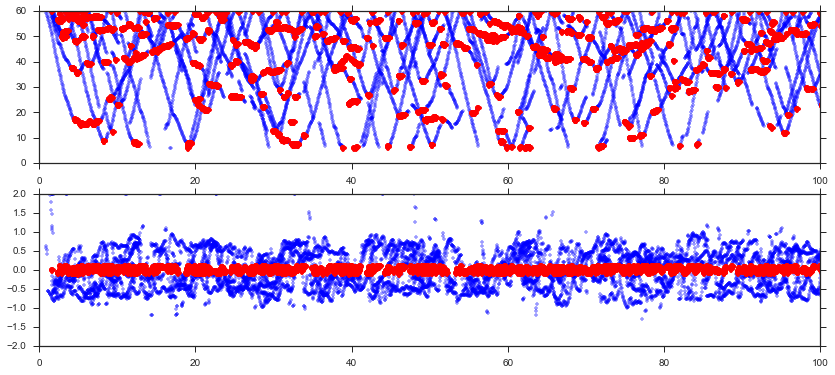

In [427]:
plt.figure(figsize=(14,6))
plt.subplot(211)
plt.plot(timeFly, objDist,'b.',alpha=0.4)
plt.plot(timeFly[abs(d_objDist)<0.1], objDist[abs(d_objDist)<0.1],'ro')
plt.plot(timeFly[objDist<6], objDist[objDist<6],'co')
plt.xlim(0,100)

plt.subplot(212)
plt.plot(timeFly, d_objDist,'b.',alpha=0.4)
plt.plot(timeFly[abs(d_objDist)<0.1], d_objDist[abs(d_objDist)<0.1],'ro')
plt.plot(timeFly[objDist<6], d_objDist[objDist<6],'co')
plt.xlim(0,100)

In [428]:
# extract indices of approach start and end

In [436]:
apr_pts = np.logical_and(filtddist<0, walkingFly>0)
apr_pts = np.logical_and(filtddist>0, walkingFly>0)

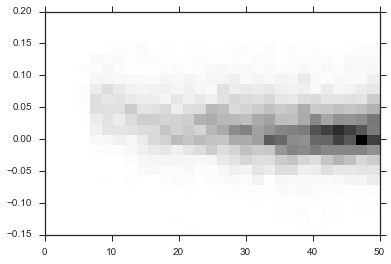

In [437]:
plt.figure(figsize = (12,5))
distEdges = np.linspace(0,50,30)
angleEdges = np.linspace(-0.15,0.15,20)

plt.subplot(121)
n, xedges, yedges = np.histogram2d(objDist[apr_pts], d_gamma[apr_pts], bins=(distEdges, angleEdges))
X, Y = np.meshgrid(yedges, xedges)
plt.pcolormesh(Y, X, n,cmap='Greys')
plt.subplot(122)
n, xedges, yedges = np.histogram2d(objDist[dep_pts], d_gamma[dep_pts], bins=(distEdges, angleEdges))
X, Y = np.meshgrid(yedges, xedges)
plt.pcolormesh(Y, X, n,cmap='Greys')

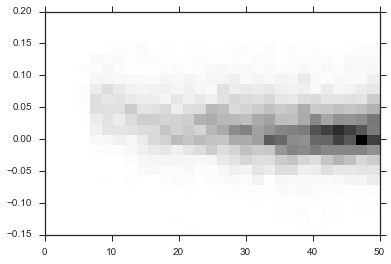

In [420]:
# TODO generate "test data", e.g. equidistant parallel lines crossing the miniarena

In [421]:
# TODO compare output of old procedural code below to output of function-based code

### Convert trajectory to polar coordinates and visualise trace and effect of turns

#### TODO: tidy up code

In [473]:
# Calculate turn threshold
# Only include moving flies
querystring = '(walking > 0)'
vRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values
time = FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1].squeeze().astype('float').values

# Find turnTH over all flies
vRot_filt = np.convolve(vRot, np.ones((5,))/5, mode='same')
turnTH_pos = 3*np.std(vRot_filt[vRot_filt>=0])
turnTH_neg = -3*np.std(vRot_filt[vRot_filt<=0])
turnTH = 3*np.std(abs(vRot_filt))

Analysis directory already exists.


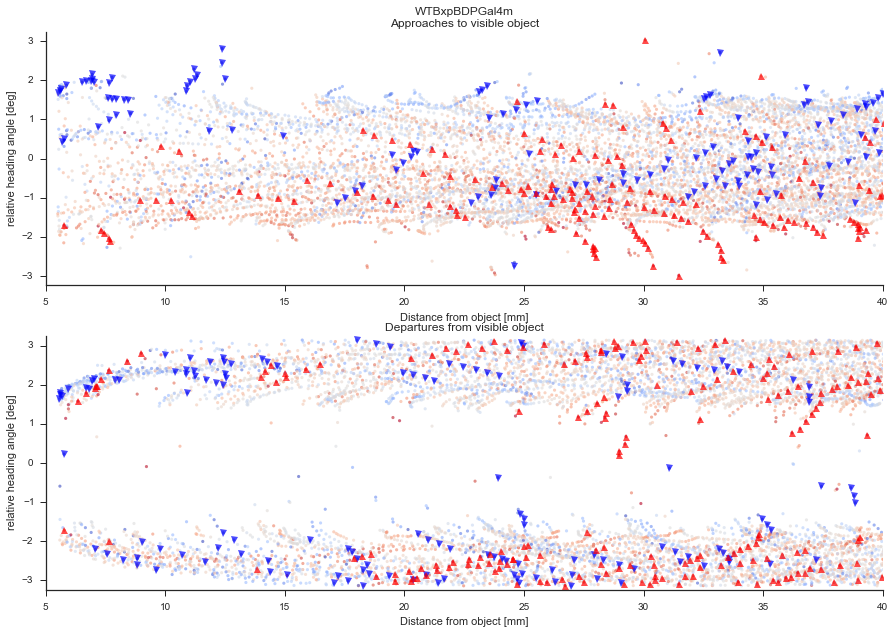

In [474]:
objecttype = "visible"
trial = 1
querystring = '(trialtype=="'+objecttype+'") & (trial=='+ str(trial) +') & (walking>0) & (objectDistance>5.5)'
xPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaFullFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
timeFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()
vTransFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
vRotFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1]).squeeze()

# transform trajectory to polar coordinates
objDist,theta = cartesian2polar(xPosFly,yPosFly)

# compute curvature
polarCurv, d_theta, dtheta_objDist = polarCurvature(theta,objDist)

d_objDist = np.hstack((0, np.diff(objDist)))

# Compute sign of turn relative to object
turnSign = np.sign(polarCurv)
turnSign[d_theta>0] = np.sign(polarCurv[d_theta>0])
turnSign[d_theta<0] = -np.sign(polarCurv[d_theta<0])

# Compute curvature-based criterion for turns
q2, q98 = np.percentile(polarCurv[~np.isnan(polarCurv)], [2 ,98])
curvSelect = abs(polarCurv)< (q98 - q2)/2

curvTurnMask_L = polarCurv > q98
curvTurnMask_R = polarCurv < q2

# Generate filtered curvature for plots and curvature magnitude
polarCurvPlt = polarCurv[curvSelect]

curvMag = abs(polarCurv)

correctedPolarCurv = abs(polarCurv)*turnSign

# Plot
vRotFly_filt = np.convolve(vRotFly, np.ones((5,))/5, mode='same')

titleString = genotypeSex

selectPts_apr = d_objDist<0
selectPts_dep = d_objDist>0

selectPts_apr_turn = np.logical_and(selectPts_apr,abs(vRotFly_filt) > turnTH)
selectPts_apr_turnR = np.logical_and(selectPts_apr,vRotFly_filt < turnTH_neg)
selectPts_apr_turnL = np.logical_and(selectPts_apr,vRotFly_filt > turnTH_pos)

selectPts_dep_turn = np.logical_and(selectPts_dep,abs(vRotFly_filt) > turnTH)
selectPts_dep_turnR = np.logical_and(selectPts_dep,vRotFly_filt < turnTH_neg)
selectPts_dep_turnL = np.logical_and(selectPts_dep,vRotFly_filt > turnTH_pos)

fig = plt.figure(figsize=(15,10))

xlimRange = (5,40)

ax=fig.add_subplot(211)
ax = plotPolarTrace(ax,titleString + '\nApproaches to ' + objecttype + ' object',
                selectPts_apr,selectPts_apr_turnR,selectPts_apr_turnL,objDist,gammaFullFly,vRotFly,xlimRange)

ax=fig.add_subplot(212)
ax = plotPolarTrace(ax,'Departures from '+ objecttype + ' object',
                selectPts_dep,selectPts_dep_turnR,selectPts_dep_turnL,objDist,gammaFullFly,vRotFly,xlimRange)

try:
    mkdir(analysisDir + sep + 'polarTrace' + sep)
except OSError:
    print('Analysis directory already exists.')

fig.savefig(analysisDir + 'polarTrace/'+genotypeSex+'_'+objecttype+'Objects'+'_n'+ str(len(flyIDs))
            +'_polarTrace_trial' + str(trial) + '.pdf', format='pdf')


Analysis directory already exists.


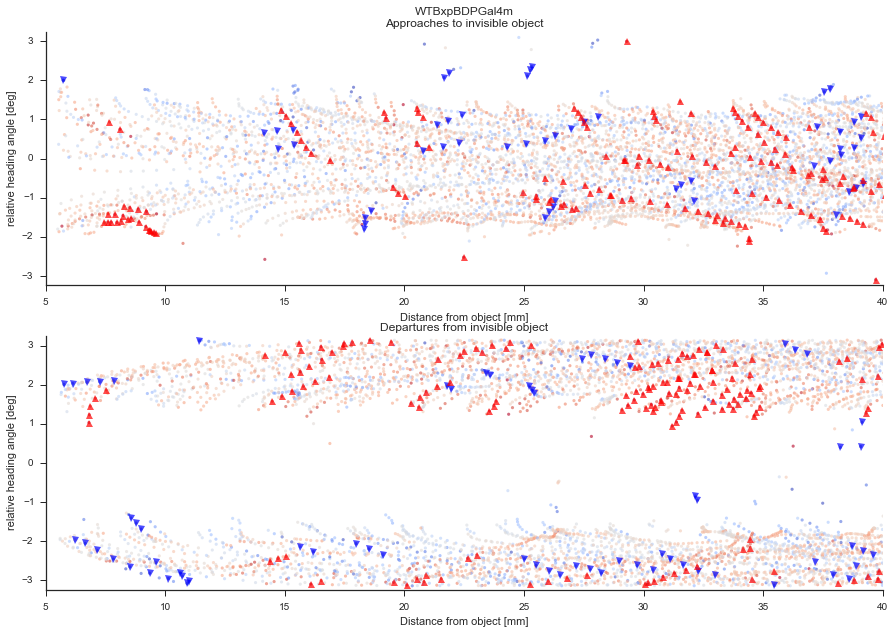

In [424]:
objecttype = "invisible"
trial = 4
querystring = '(trialtype=="'+objecttype+'") & (trial=='+ str(trial) +') & (walking>0) & (objectDistance>5.5)'
xPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaFullFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
timeFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()
vTransFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
vRotFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1]).squeeze()

# transform trajectory to polar coordinates
objDist,theta = cartesian2polar(xPosFly,yPosFly)

# compute curvature
polarCurv, d_theta, dtheta_objDist = polarCurvature(theta,objDist)

d_objDist = np.hstack((0, np.diff(objDist)))

# Compute sign of turn relative to object
turnSign = np.sign(polarCurv)
turnSign[d_theta>0] = np.sign(polarCurv[d_theta>0])
turnSign[d_theta<0] = -np.sign(polarCurv[d_theta<0])

# Compute curvature-based criterion for turns
q2, q98 = np.percentile(polarCurv[~np.isnan(polarCurv)], [2 ,98])
curvSelect = abs(polarCurv)< (q98 - q2)/2

curvTurnMask_L = polarCurv > q98
curvTurnMask_R = polarCurv < q2

# Generate filtered curvature for plots and curvature magnitude
polarCurvPlt = polarCurv[curvSelect]

curvMag = abs(polarCurv)

correctedPolarCurv = abs(polarCurv)*turnSign

# Plot
vRotFly_filt = np.convolve(vRotFly, np.ones((5,))/5, mode='same')

titleString = genotypeSex

selectPts_apr = d_objDist<0
selectPts_dep = d_objDist>0

selectPts_apr_turn = np.logical_and(selectPts_apr,abs(vRotFly_filt) > turnTH)
selectPts_apr_turnR = np.logical_and(selectPts_apr,vRotFly_filt < turnTH_neg)
selectPts_apr_turnL = np.logical_and(selectPts_apr,vRotFly_filt > turnTH_pos)

selectPts_dep_turn = np.logical_and(selectPts_dep,abs(vRotFly_filt) > turnTH)
selectPts_dep_turnR = np.logical_and(selectPts_dep,vRotFly_filt < turnTH_neg)
selectPts_dep_turnL = np.logical_and(selectPts_dep,vRotFly_filt > turnTH_pos)

fig = plt.figure(figsize=(15,10))

xlimRange = (5,40)

ax=fig.add_subplot(211)
ax = plotPolarTrace(ax,titleString + '\nApproaches to ' + objecttype + ' object',
                selectPts_apr,selectPts_apr_turnR,selectPts_apr_turnL,objDist,gammaFullFly,vRotFly,xlimRange)

ax=fig.add_subplot(212)
ax = plotPolarTrace(ax,'Departures from '+ objecttype + ' object',
                selectPts_dep,selectPts_dep_turnR,selectPts_dep_turnL,objDist,gammaFullFly,vRotFly,xlimRange)

try:
    mkdir(analysisDir + sep + 'polarTrace' + sep)
except OSError:
    print('Analysis directory already exists.')

fig.savefig(analysisDir + 'polarTrace/'+genotypeSex+'_'+objecttype+'Objects'+'_n'+ str(len(flyIDs))
            +'_polarTrace_trial' + str(trial) + '.pdf', format='pdf')